## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os

## Import pytorch libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Training folder

In [3]:
train_folder = '/Users/isaaclin/OneDrive/BS6207/4/train'

## Testing folder

In [4]:
test_folder = '/Users/isaaclin/OneDrive/BS6207/4/test'

In [5]:
classes = sorted(os.listdir(train_folder))
print(classes)

['.DS_Store', 'artifacts', 'cancer_regions', 'normal_regions', 'other']


## Prepare and augment train and validation datasets (70%-30%)

In [6]:
def load_dataset(data_path):

    # Load all the images
    # Transform the images
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training 70% and validation 30% datasets
    train_size = int(0.7 * len(full_dataset))
    validation_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/validation split
    train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size])
    
    # define a loader for the training data we can iterate through in 40-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=40,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the validation data we can iterate through in 40-image batches
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=40,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, validation_loader

In [7]:
train_loader, validation_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read /Users/isaaclin/OneDrive/BS6207/4/train


## Define CNN

In [8]:
class Net(nn.Module):
    
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        
        # In the forward function, pass the data through the layers we defined in the init function
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)

In [9]:
# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes))
print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=5, bias=True)
)


## Training function

In [10]:
def train(model, train_loader, optimizer, epoch, batch_no):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    torch.manual_seed(0)
    for batch_idx, (data, target) in enumerate(train_loader):
        # set_batch
        batch = batch_idx + 1
        # Reset the optimizer
        optimizer.zero_grad()     
        # Push the data forward through the model layers
        output = model(data)       
        # Get the loss
        loss = loss_criteria(output, target)
        # Keep a running total
        train_loss += loss.item()       
        # Backpropagate
        loss.backward()
        optimizer.step()     
        # Print metrics 
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
        if batch == batch_no:
            break
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

## Validation function

In [11]:
def validation(model, validation_loader):
    # Switch the model to evaluation mode 
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in validation_loader:
            batch_count += 1          
            # Get the predicted classes for this batch
            output = model(data)            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    validation_predict = 100. * correct / len(validation_loader.dataset)        
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct, len(validation_loader.dataset),
        validation_predict))
    
    # return average loss for the epoch
    return avg_loss, validation_predict

## Training the model (Test run)

In [12]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
batch_no = 1
early_loss = 0.0
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, batch_no)
    test_loss, validate_predict = validation(model, validation_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    #print('Early loss', early_loss)
    #print('Test loss', test_loss)
    #if round(early_loss,2) == round(test_loss,2):
    #    print("Early stopping")
    #    break
    #early_loss = test_loss  

Epoch: 1
	Training batch 1 Loss: 1.610274
Training set: Average loss: 1.610274
Validation set: Average loss: 7.206017, Accuracy: 672/1959 (34.30%)

Epoch: 2
	Training batch 1 Loss: 3.206706
Training set: Average loss: 3.206706
Validation set: Average loss: 10.556764, Accuracy: 849/1959 (43.34%)

Epoch: 3
	Training batch 1 Loss: 5.296914
Training set: Average loss: 5.296914
Validation set: Average loss: 2.361781, Accuracy: 1392/1959 (71.06%)

Epoch: 4
	Training batch 1 Loss: 0.093465
Training set: Average loss: 0.093465
Validation set: Average loss: 2.766865, Accuracy: 954/1959 (48.70%)

Epoch: 5
	Training batch 1 Loss: 0.237943
Training set: Average loss: 0.237943
Validation set: Average loss: 3.495619, Accuracy: 866/1959 (44.21%)

Epoch: 6
	Training batch 1 Loss: 0.329319
Training set: Average loss: 0.329319
Validation set: Average loss: 3.606985, Accuracy: 844/1959 (43.08%)

Epoch: 7
	Training batch 1 Loss: 0.158345
Training set: Average loss: 0.158345
Validation set: Average loss: 3

## View Loss History (Test run)

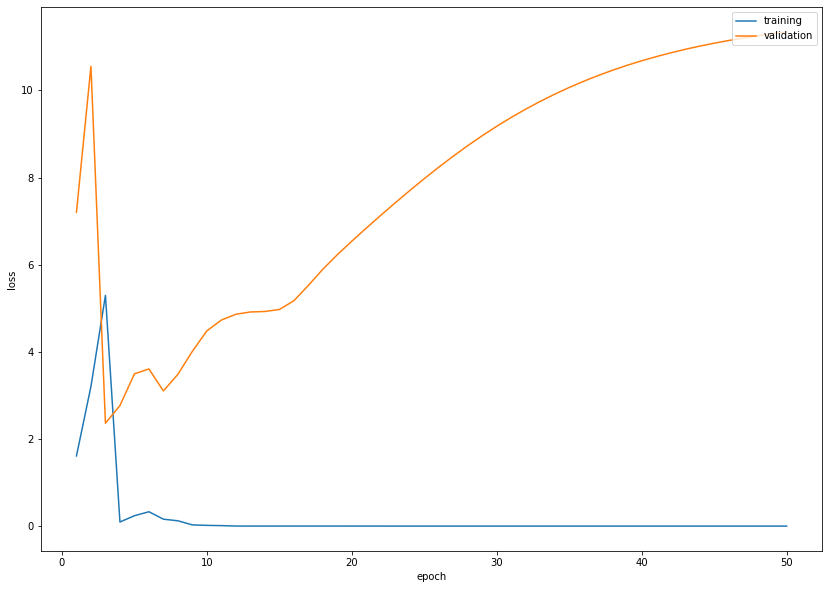

In [17]:
plt.figure(figsize=(14,10))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Prepare and augment test dataset

In [12]:
def load_testset(data_path):
    
    # Load all the images
    # Transform the images
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # define a loader for the test data we can iterate through in 40-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        num_workers=0,
        shuffle=False
    )
    
    return test_loader

## Labels and predictions

In [28]:
test_loader = load_testset(test_folder)
print("Data loaders ready to read", test_folder)

Data loaders ready to read /Users/isaaclin/OneDrive/BS6207/4/test


In [32]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
accuracy = []

# Train over 50 epochs
epochs = 50
early_loss = 0.0
for batch_no in range(1,116):
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, epoch, batch_no)
        test_loss, validation_predict = validation(model, validation_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        if round(early_loss,2) == round(validation_predict,2):
            print("Early stopping")
            break
        early_loss = validation_predict 
        
    truelabels = []
    predictions = []
    model.eval()
    print("Getting predictions from test set…")
    for data, target in test_loader:
        for label in target.data.numpy():
            truelabels.append(label)
        for prediction in model(data):
            predictions.append(torch.argmax(prediction).item())
    cm = confusion_matrix(truelabels, predictions)
    accuracy_ = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / cm.sum() * 100
    print('Accuracy: {}%'.format(accuracy_))
    accuracy.append(accuracy_)

Epoch: 1
	Training batch 1 Loss: 0.000000
Training set: Average loss: 0.000000
Validation set: Average loss: 59.063335, Accuracy: 1383/1959 (70.60%)

Epoch: 2
	Training batch 1 Loss: 0.000000
Training set: Average loss: 0.000000
Validation set: Average loss: 59.934030, Accuracy: 1384/1959 (70.65%)

Epoch: 3
	Training batch 1 Loss: 0.000000
Training set: Average loss: 0.000000
Validation set: Average loss: 60.480829, Accuracy: 1384/1959 (70.65%)

Early stopping
Getting predictions from test set…
Accuracy: 46.5%
Epoch: 1
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 53.180378
Training set: Average loss: 26.590189
Validation set: Average loss: 31.328044, Accuracy: 1434/1959 (73.20%)

Epoch: 2
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 29.693628
Training set: Average loss: 14.846814
Validation set: Average loss: 46.200915, Accuracy: 924/1959 (47.17%)

Epoch: 3
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 17.340406
Training set: Average loss: 8.670203
Va

Validation set: Average loss: 1.899030, Accuracy: 1276/1959 (65.14%)

Epoch: 4
	Training batch 1 Loss: 0.000340
	Training batch 2 Loss: 0.143683
	Training batch 3 Loss: 0.056802
	Training batch 4 Loss: 0.992354
Training set: Average loss: 0.298295
Validation set: Average loss: 1.375687, Accuracy: 1330/1959 (67.89%)

Epoch: 5
	Training batch 1 Loss: 0.001412
	Training batch 2 Loss: 0.151069
	Training batch 3 Loss: 0.166361
	Training batch 4 Loss: 0.452170
Training set: Average loss: 0.192753
Validation set: Average loss: 1.332851, Accuracy: 1071/1959 (54.67%)

Epoch: 6
	Training batch 1 Loss: 0.013197
	Training batch 2 Loss: 0.034916
	Training batch 3 Loss: 0.043482
	Training batch 4 Loss: 0.629066
Training set: Average loss: 0.180165
Validation set: Average loss: 1.284515, Accuracy: 1408/1959 (71.87%)

Epoch: 7
	Training batch 1 Loss: 0.007537
	Training batch 2 Loss: 0.008781
	Training batch 3 Loss: 0.041412
	Training batch 4 Loss: 0.038069
Training set: Average loss: 0.023950
Validati

	Training batch 1 Loss: 0.000121
	Training batch 2 Loss: 0.001259
	Training batch 3 Loss: 0.000557
	Training batch 4 Loss: 0.001464
	Training batch 5 Loss: 0.009217
	Training batch 6 Loss: 0.013514
	Training batch 7 Loss: 1.852692
Training set: Average loss: 0.268403
Validation set: Average loss: 1.789890, Accuracy: 1396/1959 (71.26%)

Epoch: 2
	Training batch 1 Loss: 0.000147
	Training batch 2 Loss: 0.001637
	Training batch 3 Loss: 0.010365
	Training batch 4 Loss: 0.063352
	Training batch 5 Loss: 0.286354
	Training batch 6 Loss: 0.089617
	Training batch 7 Loss: 0.929386
Training set: Average loss: 0.197266
Validation set: Average loss: 1.652267, Accuracy: 1337/1959 (68.25%)

Epoch: 3
	Training batch 1 Loss: 0.000707
	Training batch 2 Loss: 0.004961
	Training batch 3 Loss: 0.032547
	Training batch 4 Loss: 0.027095
	Training batch 5 Loss: 0.281792
	Training batch 6 Loss: 0.182895
	Training batch 7 Loss: 0.260440
Training set: Average loss: 0.112920
Validation set: Average loss: 1.275927

Validation set: Average loss: 2.474049, Accuracy: 1365/1959 (69.68%)

Epoch: 9
	Training batch 1 Loss: 0.000079
	Training batch 2 Loss: 0.000264
	Training batch 3 Loss: 0.000273
	Training batch 4 Loss: 0.000795
	Training batch 5 Loss: 0.001418
	Training batch 6 Loss: 0.002826
	Training batch 7 Loss: 0.002744
	Training batch 8 Loss: 0.003161
Training set: Average loss: 0.001445
Validation set: Average loss: 2.508181, Accuracy: 1370/1959 (69.93%)

Epoch: 10
	Training batch 1 Loss: 0.000058
	Training batch 2 Loss: 0.000205
	Training batch 3 Loss: 0.000220
	Training batch 4 Loss: 0.000650
	Training batch 5 Loss: 0.001238
	Training batch 6 Loss: 0.002337
	Training batch 7 Loss: 0.002201
	Training batch 8 Loss: 0.002560
Training set: Average loss: 0.001183
Validation set: Average loss: 2.541106, Accuracy: 1375/1959 (70.19%)

Epoch: 11
	Training batch 1 Loss: 0.000046
	Training batch 2 Loss: 0.000169
	Training batch 3 Loss: 0.000186
	Training batch 4 Loss: 0.000558
	Training batch 5 Loss: 0.0

	Training batch 8 Loss: 0.072666
	Training batch 9 Loss: 0.007040
	Training batch 10 Loss: 0.232119
Training set: Average loss: 0.040767
Validation set: Average loss: 3.578167, Accuracy: 1297/1959 (66.21%)

Epoch: 5
	Training batch 1 Loss: 0.003890
	Training batch 2 Loss: 0.000987
	Training batch 3 Loss: 0.021068
	Training batch 4 Loss: 0.000149
	Training batch 5 Loss: 0.001578
	Training batch 6 Loss: 0.003174
	Training batch 7 Loss: 0.207532
	Training batch 8 Loss: 0.004377
	Training batch 9 Loss: 0.000049
	Training batch 10 Loss: 0.010661
Training set: Average loss: 0.025346
Validation set: Average loss: 3.013971, Accuracy: 1320/1959 (67.38%)

Epoch: 6
	Training batch 1 Loss: 0.000133
	Training batch 2 Loss: 0.000203
	Training batch 3 Loss: 0.000721
	Training batch 4 Loss: 0.003632
	Training batch 5 Loss: 0.001285
	Training batch 6 Loss: 0.004908
	Training batch 7 Loss: 0.005162
	Training batch 8 Loss: 0.003685
	Training batch 9 Loss: 0.012888
	Training batch 10 Loss: 0.740307
Traini

	Training batch 7 Loss: 0.010190
	Training batch 8 Loss: 0.018094
	Training batch 9 Loss: 0.001650
	Training batch 10 Loss: 0.018831
	Training batch 11 Loss: 0.041187
Training set: Average loss: 0.010359
Validation set: Average loss: 2.043687, Accuracy: 1401/1959 (71.52%)

Epoch: 6
	Training batch 1 Loss: 0.000186
	Training batch 2 Loss: 0.000239
	Training batch 3 Loss: 0.000722
	Training batch 4 Loss: 0.001208
	Training batch 5 Loss: 0.002814
	Training batch 6 Loss: 0.004019
	Training batch 7 Loss: 0.002504
	Training batch 8 Loss: 0.001538
	Training batch 9 Loss: 0.000350
	Training batch 10 Loss: 0.002837
	Training batch 11 Loss: 0.027354
Training set: Average loss: 0.003979
Validation set: Average loss: 2.160728, Accuracy: 1405/1959 (71.72%)

Epoch: 7
	Training batch 1 Loss: 0.000048
	Training batch 2 Loss: 0.000118
	Training batch 3 Loss: 0.000493
	Training batch 4 Loss: 0.000597
	Training batch 5 Loss: 0.000951
	Training batch 6 Loss: 0.001623
	Training batch 7 Loss: 0.001106
	Trai

	Training batch 1 Loss: 0.000025
	Training batch 2 Loss: 0.000075
	Training batch 3 Loss: 0.003481
	Training batch 4 Loss: 0.000076
	Training batch 5 Loss: 0.000096
	Training batch 6 Loss: 0.015451
	Training batch 7 Loss: 0.000709
	Training batch 8 Loss: 0.000337
	Training batch 9 Loss: 0.000005
	Training batch 10 Loss: 0.000301
	Training batch 11 Loss: 0.022677
	Training batch 12 Loss: 0.000492
	Training batch 13 Loss: 0.047081
Training set: Average loss: 0.006985
Validation set: Average loss: 2.573052, Accuracy: 1362/1959 (69.53%)

Epoch: 7
	Training batch 1 Loss: 0.000031
	Training batch 2 Loss: 0.000204
	Training batch 3 Loss: 0.000140
	Training batch 4 Loss: 0.000061
	Training batch 5 Loss: 0.000094
	Training batch 6 Loss: 0.000013
	Training batch 7 Loss: 0.000949
	Training batch 8 Loss: 0.000250
	Training batch 9 Loss: 0.000003
	Training batch 10 Loss: 0.000214
	Training batch 11 Loss: 0.019308
	Training batch 12 Loss: 0.000305
	Training batch 13 Loss: 0.041054
Training set: Aver

	Training batch 1 Loss: 0.000002
	Training batch 2 Loss: 0.000010
	Training batch 3 Loss: 0.000003
	Training batch 4 Loss: 0.000006
	Training batch 5 Loss: 0.000038
	Training batch 6 Loss: 0.000002
	Training batch 7 Loss: 0.000090
	Training batch 8 Loss: 0.000017
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000032
	Training batch 11 Loss: 0.003021
	Training batch 12 Loss: 0.000103
	Training batch 13 Loss: 0.001200
Training set: Average loss: 0.000348
Validation set: Average loss: 3.194849, Accuracy: 1374/1959 (70.14%)

Epoch: 22
	Training batch 1 Loss: 0.000002
	Training batch 2 Loss: 0.000009
	Training batch 3 Loss: 0.000002
	Training batch 4 Loss: 0.000006
	Training batch 5 Loss: 0.000038
	Training batch 6 Loss: 0.000002
	Training batch 7 Loss: 0.000083
	Training batch 8 Loss: 0.000016
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000030
	Training batch 11 Loss: 0.002750
	Training batch 12 Loss: 0.000100
	Training batch 13 Loss: 0.001059
Training set: Ave

	Training batch 2 Loss: 0.000013
	Training batch 3 Loss: 0.000092
	Training batch 4 Loss: 0.000083
	Training batch 5 Loss: 0.000046
	Training batch 6 Loss: 0.000076
	Training batch 7 Loss: 0.000073
	Training batch 8 Loss: 0.000048
	Training batch 9 Loss: 0.000003
	Training batch 10 Loss: 0.000101
	Training batch 11 Loss: 0.003705
	Training batch 12 Loss: 0.000109
	Training batch 13 Loss: 0.001016
	Training batch 14 Loss: 0.000170
Training set: Average loss: 0.000399
Validation set: Average loss: 3.246818, Accuracy: 1357/1959 (69.27%)

Epoch: 14
	Training batch 1 Loss: 0.000044
	Training batch 2 Loss: 0.000011
	Training batch 3 Loss: 0.000086
	Training batch 4 Loss: 0.000072
	Training batch 5 Loss: 0.000042
	Training batch 6 Loss: 0.000068
	Training batch 7 Loss: 0.000064
	Training batch 8 Loss: 0.000044
	Training batch 9 Loss: 0.000002
	Training batch 10 Loss: 0.000086
	Training batch 11 Loss: 0.003294
	Training batch 12 Loss: 0.000098
	Training batch 13 Loss: 0.000848
	Training batch 

	Training batch 6 Loss: 0.006338
	Training batch 7 Loss: 0.022793
	Training batch 8 Loss: 0.038498
	Training batch 9 Loss: 0.012567
	Training batch 10 Loss: 0.010777
	Training batch 11 Loss: 0.063173
	Training batch 12 Loss: 0.094415
	Training batch 13 Loss: 0.045677
	Training batch 14 Loss: 0.079099
	Training batch 15 Loss: 0.010406
	Training batch 16 Loss: 0.151118
Training set: Average loss: 0.034580
Validation set: Average loss: 1.636311, Accuracy: 1412/1959 (72.08%)

Epoch: 3
	Training batch 1 Loss: 0.000658
	Training batch 2 Loss: 0.001539
	Training batch 3 Loss: 0.000505
	Training batch 4 Loss: 0.007607
	Training batch 5 Loss: 0.005514
	Training batch 6 Loss: 0.007814
	Training batch 7 Loss: 0.014170
	Training batch 8 Loss: 0.005286
	Training batch 9 Loss: 0.028290
	Training batch 10 Loss: 0.040898
	Training batch 11 Loss: 0.073948
	Training batch 12 Loss: 0.000740
	Training batch 13 Loss: 0.023931
	Training batch 14 Loss: 0.014114
	Training batch 15 Loss: 0.001454
	Training bat

Validation set: Average loss: 3.526456, Accuracy: 1385/1959 (70.70%)

Epoch: 15
	Training batch 1 Loss: 0.000006
	Training batch 2 Loss: 0.000048
	Training batch 3 Loss: 0.000137
	Training batch 4 Loss: 0.000111
	Training batch 5 Loss: 0.000103
	Training batch 6 Loss: 0.000073
	Training batch 7 Loss: 0.000097
	Training batch 8 Loss: 0.000069
	Training batch 9 Loss: 0.000002
	Training batch 10 Loss: 0.000007
	Training batch 11 Loss: 0.000773
	Training batch 12 Loss: 0.000067
	Training batch 13 Loss: 0.000460
	Training batch 14 Loss: 0.000044
	Training batch 15 Loss: 0.000185
	Training batch 16 Loss: 0.000212
Training set: Average loss: 0.000150
Validation set: Average loss: 3.554444, Accuracy: 1386/1959 (70.75%)

Epoch: 16
	Training batch 1 Loss: 0.000005
	Training batch 2 Loss: 0.000044
	Training batch 3 Loss: 0.000127
	Training batch 4 Loss: 0.000105
	Training batch 5 Loss: 0.000095
	Training batch 6 Loss: 0.000068
	Training batch 7 Loss: 0.000090
	Training batch 8 Loss: 0.000064
	Tra

	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000019
	Training batch 3 Loss: 0.000040
	Training batch 4 Loss: 0.000083
	Training batch 5 Loss: 0.000028
	Training batch 6 Loss: 0.000036
	Training batch 7 Loss: 0.000189
	Training batch 8 Loss: 0.000087
	Training batch 9 Loss: 0.000017
	Training batch 10 Loss: 0.000047
	Training batch 11 Loss: 0.000305
	Training batch 12 Loss: 0.000172
	Training batch 13 Loss: 0.001034
	Training batch 14 Loss: 0.000052
	Training batch 15 Loss: 0.000043
	Training batch 16 Loss: 0.000051
	Training batch 17 Loss: 0.000144
Training set: Average loss: 0.000138
Validation set: Average loss: 3.149723, Accuracy: 1414/1959 (72.18%)

Early stopping
Getting predictions from test set…
Accuracy: 46.5%
Epoch: 1
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000012
	Training batch 3 Loss: 0.000032
	Training batch 4 Loss: 0.000073
	Training batch 5 Loss: 0.000025
	Training batch 6 Loss: 0.000032
	Training batch 7 Loss: 0.000151
	Training batch 8 

	Training batch 6 Loss: 0.225743
	Training batch 7 Loss: 0.255878
	Training batch 8 Loss: 0.251060
	Training batch 9 Loss: 0.365291
	Training batch 10 Loss: 0.372648
	Training batch 11 Loss: 0.099286
	Training batch 12 Loss: 0.131550
	Training batch 13 Loss: 0.207750
	Training batch 14 Loss: 0.108914
	Training batch 15 Loss: 0.211365
	Training batch 16 Loss: 0.173575
	Training batch 17 Loss: 0.114900
	Training batch 18 Loss: 0.119424
	Training batch 19 Loss: 0.408457
Training set: Average loss: 0.179760
Validation set: Average loss: 1.753134, Accuracy: 1291/1959 (65.90%)

Epoch: 3
	Training batch 1 Loss: 0.014625
	Training batch 2 Loss: 0.013852
	Training batch 3 Loss: 0.025259
	Training batch 4 Loss: 0.033701
	Training batch 5 Loss: 0.003237
	Training batch 6 Loss: 0.013525
	Training batch 7 Loss: 0.014321
	Training batch 8 Loss: 0.001419
	Training batch 9 Loss: 0.000777
	Training batch 10 Loss: 0.004310
	Training batch 11 Loss: 0.023930
	Training batch 12 Loss: 0.067321
	Training bat

	Training batch 20 Loss: 0.000898
Training set: Average loss: 0.002992
Validation set: Average loss: 3.317397, Accuracy: 1384/1959 (70.65%)

Epoch: 6
	Training batch 1 Loss: 0.000345
	Training batch 2 Loss: 0.000077
	Training batch 3 Loss: 0.000024
	Training batch 4 Loss: 0.000026
	Training batch 5 Loss: 0.000886
	Training batch 6 Loss: 0.000086
	Training batch 7 Loss: 0.000086
	Training batch 8 Loss: 0.000058
	Training batch 9 Loss: 0.000007
	Training batch 10 Loss: 0.000363
	Training batch 11 Loss: 0.000203
	Training batch 12 Loss: 0.000043
	Training batch 13 Loss: 0.011176
	Training batch 14 Loss: 0.000099
	Training batch 15 Loss: 0.004753
	Training batch 16 Loss: 0.000067
	Training batch 17 Loss: 0.000779
	Training batch 18 Loss: 0.000099
	Training batch 19 Loss: 0.003025
	Training batch 20 Loss: 0.000518
Training set: Average loss: 0.001136
Validation set: Average loss: 3.405329, Accuracy: 1373/1959 (70.09%)

Epoch: 7
	Training batch 1 Loss: 0.000238
	Training batch 2 Loss: 0.0000

	Training batch 7 Loss: 0.000027
	Training batch 8 Loss: 0.000033
	Training batch 9 Loss: 0.000005
	Training batch 10 Loss: 0.000038
	Training batch 11 Loss: 0.000186
	Training batch 12 Loss: 0.000006
	Training batch 13 Loss: 0.000107
	Training batch 14 Loss: 0.000041
	Training batch 15 Loss: 0.000699
	Training batch 16 Loss: 0.000136
	Training batch 17 Loss: 0.000222
	Training batch 18 Loss: 0.000004
	Training batch 19 Loss: 0.000902
	Training batch 20 Loss: 0.000161
Training set: Average loss: 0.000138
Validation set: Average loss: 3.371467, Accuracy: 1362/1959 (69.53%)

Epoch: 17
	Training batch 1 Loss: 0.000058
	Training batch 2 Loss: 0.000019
	Training batch 3 Loss: 0.000016
	Training batch 4 Loss: 0.000032
	Training batch 5 Loss: 0.000005
	Training batch 6 Loss: 0.000046
	Training batch 7 Loss: 0.000023
	Training batch 8 Loss: 0.000028
	Training batch 9 Loss: 0.000004
	Training batch 10 Loss: 0.000035
	Training batch 11 Loss: 0.000160
	Training batch 12 Loss: 0.000005
	Training b

	Training batch 11 Loss: 0.000234
	Training batch 12 Loss: 0.000257
	Training batch 13 Loss: 0.000562
	Training batch 14 Loss: 0.000286
	Training batch 15 Loss: 0.000348
	Training batch 16 Loss: 0.000064
	Training batch 17 Loss: 0.000115
	Training batch 18 Loss: 0.000056
	Training batch 19 Loss: 0.001297
	Training batch 20 Loss: 0.000547
	Training batch 21 Loss: 0.000728
Training set: Average loss: 0.000455
Validation set: Average loss: 2.997851, Accuracy: 1375/1959 (70.19%)

Epoch: 6
	Training batch 1 Loss: 0.000090
	Training batch 2 Loss: 0.000262
	Training batch 3 Loss: 0.000035
	Training batch 4 Loss: 0.000425
	Training batch 5 Loss: 0.000268
	Training batch 6 Loss: 0.000017
	Training batch 7 Loss: 0.000060
	Training batch 8 Loss: 0.000044
	Training batch 9 Loss: 0.000004
	Training batch 10 Loss: 0.000451
	Training batch 11 Loss: 0.000158
	Training batch 12 Loss: 0.000160
	Training batch 13 Loss: 0.000401
	Training batch 14 Loss: 0.000193
	Training batch 15 Loss: 0.000246
	Training

	Training batch 5 Loss: 0.000440
	Training batch 6 Loss: 0.000206
	Training batch 7 Loss: 0.000257
	Training batch 8 Loss: 0.000752
	Training batch 9 Loss: 0.000996
	Training batch 10 Loss: 0.000361
	Training batch 11 Loss: 0.000290
	Training batch 12 Loss: 0.000065
	Training batch 13 Loss: 0.000416
	Training batch 14 Loss: 0.000081
	Training batch 15 Loss: 0.000844
	Training batch 16 Loss: 0.000088
	Training batch 17 Loss: 0.000310
	Training batch 18 Loss: 0.000050
	Training batch 19 Loss: 0.000321
	Training batch 20 Loss: 0.000766
	Training batch 21 Loss: 0.000211
	Training batch 22 Loss: 0.000501
Training set: Average loss: 0.000438
Validation set: Average loss: 3.212896, Accuracy: 1357/1959 (69.27%)

Epoch: 6
	Training batch 1 Loss: 0.000025
	Training batch 2 Loss: 0.000682
	Training batch 3 Loss: 0.000220
	Training batch 4 Loss: 0.000041
	Training batch 5 Loss: 0.000256
	Training batch 6 Loss: 0.000035
	Training batch 7 Loss: 0.000144
	Training batch 8 Loss: 0.000248
	Training bat

	Training batch 16 Loss: 0.001166
	Training batch 17 Loss: 0.009380
	Training batch 18 Loss: 0.000305
	Training batch 19 Loss: 0.012665
	Training batch 20 Loss: 0.003014
	Training batch 21 Loss: 0.000165
	Training batch 22 Loss: 0.014602
	Training batch 23 Loss: 0.004489
Training set: Average loss: 0.004941
Validation set: Average loss: 2.504029, Accuracy: 1376/1959 (70.24%)

Epoch: 4
	Training batch 1 Loss: 0.000336
	Training batch 2 Loss: 0.000500
	Training batch 3 Loss: 0.000037
	Training batch 4 Loss: 0.002358
	Training batch 5 Loss: 0.000182
	Training batch 6 Loss: 0.000418
	Training batch 7 Loss: 0.000164
	Training batch 8 Loss: 0.000413
	Training batch 9 Loss: 0.000114
	Training batch 10 Loss: 0.000382
	Training batch 11 Loss: 0.000691
	Training batch 12 Loss: 0.000068
	Training batch 13 Loss: 0.001217
	Training batch 14 Loss: 0.000067
	Training batch 15 Loss: 0.004122
	Training batch 16 Loss: 0.000288
	Training batch 17 Loss: 0.001461
	Training batch 18 Loss: 0.000450
	Training

	Training batch 19 Loss: 0.099176
	Training batch 20 Loss: 0.125825
	Training batch 21 Loss: 0.028987
	Training batch 22 Loss: 0.013380
	Training batch 23 Loss: 0.009269
	Training batch 24 Loss: 0.258745
Training set: Average loss: 0.095579
Validation set: Average loss: 2.988599, Accuracy: 1368/1959 (69.83%)

Epoch: 3
	Training batch 1 Loss: 0.068271
	Training batch 2 Loss: 0.015772
	Training batch 3 Loss: 0.097879
	Training batch 4 Loss: 0.002827
	Training batch 5 Loss: 0.123135
	Training batch 6 Loss: 0.000312
	Training batch 7 Loss: 0.000304
	Training batch 8 Loss: 0.000090
	Training batch 9 Loss: 0.000013
	Training batch 10 Loss: 0.000289
	Training batch 11 Loss: 0.000196
	Training batch 12 Loss: 0.000103
	Training batch 13 Loss: 0.000290
	Training batch 14 Loss: 0.001936
	Training batch 15 Loss: 0.002051
	Training batch 16 Loss: 0.000003
	Training batch 17 Loss: 0.000073
	Training batch 18 Loss: 0.227466
	Training batch 19 Loss: 0.429269
	Training batch 20 Loss: 0.000359
	Training

	Training batch 16 Loss: 0.000003
	Training batch 17 Loss: 0.000048
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000805
	Training batch 20 Loss: 0.000004
	Training batch 21 Loss: 0.000024
	Training batch 22 Loss: 0.000006
	Training batch 23 Loss: 0.000009
	Training batch 24 Loss: 0.000030
Training set: Average loss: 0.000064
Validation set: Average loss: 5.277289, Accuracy: 1375/1959 (70.19%)

Early stopping
Getting predictions from test set…
Accuracy: 47.0%
Epoch: 1
	Training batch 1 Loss: 0.000002
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000003
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000001
	Training batch 6 Loss: 0.000010
	Training batch 7 Loss: 0.000048
	Training batch 8 Loss: 0.000014
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000027
	Training batch 11 Loss: 0.000009
	Training batch 12 Loss: 0.000006
	Training batch 13 Loss: 0.000345
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000032
	Training b

	Training batch 25 Loss: 0.000001
	Training batch 26 Loss: 0.002029
Training set: Average loss: 0.001669
Validation set: Average loss: 3.409650, Accuracy: 1325/1959 (67.64%)

Epoch: 6
	Training batch 1 Loss: 0.000351
	Training batch 2 Loss: 0.000147
	Training batch 3 Loss: 0.000931
	Training batch 4 Loss: 0.000268
	Training batch 5 Loss: 0.000179
	Training batch 6 Loss: 0.000250
	Training batch 7 Loss: 0.001799
	Training batch 8 Loss: 0.000050
	Training batch 9 Loss: 0.000004
	Training batch 10 Loss: 0.000110
	Training batch 11 Loss: 0.000026
	Training batch 12 Loss: 0.000095
	Training batch 13 Loss: 0.000714
	Training batch 14 Loss: 0.000007
	Training batch 15 Loss: 0.000069
	Training batch 16 Loss: 0.000093
	Training batch 17 Loss: 0.000134
	Training batch 18 Loss: 0.000006
	Training batch 19 Loss: 0.001478
	Training batch 20 Loss: 0.000213
	Training batch 21 Loss: 0.000166
	Training batch 22 Loss: 0.000155
	Training batch 23 Loss: 0.000245
	Training batch 24 Loss: 0.000159
	Training

	Training batch 4 Loss: 0.000039
	Training batch 5 Loss: 0.000042
	Training batch 6 Loss: 0.000028
	Training batch 7 Loss: 0.000208
	Training batch 8 Loss: 0.000009
	Training batch 9 Loss: 0.000001
	Training batch 10 Loss: 0.000030
	Training batch 11 Loss: 0.000009
	Training batch 12 Loss: 0.000013
	Training batch 13 Loss: 0.000217
	Training batch 14 Loss: 0.000002
	Training batch 15 Loss: 0.000022
	Training batch 16 Loss: 0.000037
	Training batch 17 Loss: 0.000058
	Training batch 18 Loss: 0.000002
	Training batch 19 Loss: 0.000447
	Training batch 20 Loss: 0.000036
	Training batch 21 Loss: 0.000081
	Training batch 22 Loss: 0.000031
	Training batch 23 Loss: 0.000092
	Training batch 24 Loss: 0.000040
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000211
Training set: Average loss: 0.000067
Validation set: Average loss: 3.879548, Accuracy: 1345/1959 (68.66%)

Early stopping
Getting predictions from test set…
Accuracy: 48.0%
Epoch: 1
	Training batch 1 Loss: 0.000031
	Training

	Training batch 3 Loss: 0.000038
	Training batch 4 Loss: 0.000002
	Training batch 5 Loss: 0.000010
	Training batch 6 Loss: 0.000003
	Training batch 7 Loss: 0.000104
	Training batch 8 Loss: 0.000044
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000023
	Training batch 11 Loss: 0.000005
	Training batch 12 Loss: 0.000004
	Training batch 13 Loss: 0.000024
	Training batch 14 Loss: 0.000004
	Training batch 15 Loss: 0.000009
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000012
	Training batch 18 Loss: 0.000013
	Training batch 19 Loss: 0.000074
	Training batch 20 Loss: 0.000008
	Training batch 21 Loss: 0.000043
	Training batch 22 Loss: 0.000014
	Training batch 23 Loss: 0.000037
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000015
	Training batch 26 Loss: 0.000091
	Training batch 27 Loss: 0.000461
Training set: Average loss: 0.000041
Validation set: Average loss: 4.242630, Accuracy: 1361/1959 (69.47%)

Early stopping
Getting predictions from test set…


	Training batch 26 Loss: 0.000020
	Training batch 27 Loss: 0.000004
	Training batch 28 Loss: 0.000020
Training set: Average loss: 0.000044
Validation set: Average loss: 3.922075, Accuracy: 1395/1959 (71.21%)

Early stopping
Getting predictions from test set…
Accuracy: 47.75%
Epoch: 1
	Training batch 1 Loss: 0.000010
	Training batch 2 Loss: 0.000004
	Training batch 3 Loss: 0.000008
	Training batch 4 Loss: 0.000095
	Training batch 5 Loss: 0.000015
	Training batch 6 Loss: 0.000013
	Training batch 7 Loss: 0.000057
	Training batch 8 Loss: 0.000001
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000031
	Training batch 11 Loss: 0.000019
	Training batch 12 Loss: 0.000005
	Training batch 13 Loss: 0.000045
	Training batch 14 Loss: 0.000031
	Training batch 15 Loss: 0.000012
	Training batch 16 Loss: 0.000121
	Training batch 17 Loss: 0.000052
	Training batch 18 Loss: 0.000010
	Training batch 19 Loss: 0.000309
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000052
	Training 

	Training batch 4 Loss: 0.000050
	Training batch 5 Loss: 0.000022
	Training batch 6 Loss: 0.004549
	Training batch 7 Loss: 0.000256
	Training batch 8 Loss: 0.000652
	Training batch 9 Loss: 0.046135
	Training batch 10 Loss: 0.000281
	Training batch 11 Loss: 0.001244
	Training batch 12 Loss: 0.000016
	Training batch 13 Loss: 0.000010
	Training batch 14 Loss: 0.000031
	Training batch 15 Loss: 0.000151
	Training batch 16 Loss: 0.000010
	Training batch 17 Loss: 0.000612
	Training batch 18 Loss: 0.000217
	Training batch 19 Loss: 0.000340
	Training batch 20 Loss: 0.000002
	Training batch 21 Loss: 0.000134
	Training batch 22 Loss: 0.000014
	Training batch 23 Loss: 0.000221
	Training batch 24 Loss: 0.000115
	Training batch 25 Loss: 0.000008
	Training batch 26 Loss: 0.000014
	Training batch 27 Loss: 0.000025
	Training batch 28 Loss: 0.000102
	Training batch 29 Loss: 0.000679
	Training batch 30 Loss: 0.001846
Training set: Average loss: 0.001934
Validation set: Average loss: 3.752125, Accuracy: 1

	Training batch 8 Loss: 0.002261
	Training batch 9 Loss: 0.000006
	Training batch 10 Loss: 0.113707
	Training batch 11 Loss: 0.000008
	Training batch 12 Loss: 0.000011
	Training batch 13 Loss: 0.000075
	Training batch 14 Loss: 0.002544
	Training batch 15 Loss: 0.000080
	Training batch 16 Loss: 0.000008
	Training batch 17 Loss: 0.002637
	Training batch 18 Loss: 0.000705
	Training batch 19 Loss: 0.000021
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.000016
	Training batch 22 Loss: 0.000010
	Training batch 23 Loss: 0.000079
	Training batch 24 Loss: 0.000003
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000022
	Training batch 27 Loss: 0.000012
	Training batch 28 Loss: 0.000004
	Training batch 29 Loss: 0.000042
	Training batch 30 Loss: 0.003399
	Training batch 31 Loss: 0.000037
Training set: Average loss: 0.004078
Validation set: Average loss: 3.935279, Accuracy: 1425/1959 (72.74%)

Epoch: 6
	Training batch 1 Loss: 0.000079
	Training batch 2 Loss: 0.000004
	Tra

	Training batch 7 Loss: 0.809265
	Training batch 8 Loss: 0.008246
	Training batch 9 Loss: 0.041175
	Training batch 10 Loss: 0.006258
	Training batch 11 Loss: 0.189882
	Training batch 12 Loss: 0.022803
	Training batch 13 Loss: 0.053108
	Training batch 14 Loss: 0.053055
	Training batch 15 Loss: 0.023808
	Training batch 16 Loss: 0.023969
	Training batch 17 Loss: 0.049152
	Training batch 18 Loss: 0.044465
	Training batch 19 Loss: 0.038610
	Training batch 20 Loss: 0.026262
	Training batch 21 Loss: 0.170137
	Training batch 22 Loss: 0.081748
	Training batch 23 Loss: 0.096274
	Training batch 24 Loss: 0.074096
	Training batch 25 Loss: 0.010829
	Training batch 26 Loss: 0.041789
	Training batch 27 Loss: 0.066406
	Training batch 28 Loss: 0.176911
	Training batch 29 Loss: 0.156743
	Training batch 30 Loss: 0.103201
	Training batch 31 Loss: 0.122661
	Training batch 32 Loss: 0.290605
Training set: Average loss: 0.103328
Validation set: Average loss: 3.282412, Accuracy: 1370/1959 (69.93%)

Epoch: 3
	Tr

	Training batch 2 Loss: 0.001640
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.006851
	Training batch 5 Loss: 0.130503
	Training batch 6 Loss: 0.122198
	Training batch 7 Loss: 0.000085
	Training batch 8 Loss: 0.000223
	Training batch 9 Loss: 0.000131
	Training batch 10 Loss: 0.004984
	Training batch 11 Loss: 0.000016
	Training batch 12 Loss: 0.643798
	Training batch 13 Loss: 0.005664
	Training batch 14 Loss: 0.069389
	Training batch 15 Loss: 0.244207
	Training batch 16 Loss: 0.000837
	Training batch 17 Loss: 0.000081
	Training batch 18 Loss: 0.266433
	Training batch 19 Loss: 0.002361
	Training batch 20 Loss: 0.037133
	Training batch 21 Loss: 0.016372
	Training batch 22 Loss: 0.043303
	Training batch 23 Loss: 0.047451
	Training batch 24 Loss: 0.000384
	Training batch 25 Loss: 0.242300
	Training batch 26 Loss: 0.095327
	Training batch 27 Loss: 0.000039
	Training batch 28 Loss: 0.009679
	Training batch 29 Loss: 0.000097
	Training batch 30 Loss: 0.023830
	Training batch 31 Los

Validation set: Average loss: 6.709929, Accuracy: 1342/1959 (68.50%)

Epoch: 16
	Training batch 1 Loss: 0.000012
	Training batch 2 Loss: 0.000032
	Training batch 3 Loss: 0.000012
	Training batch 4 Loss: 0.000092
	Training batch 5 Loss: 0.000169
	Training batch 6 Loss: 0.000328
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000022
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000058
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000255
	Training batch 14 Loss: 0.045955
	Training batch 15 Loss: 0.000002
	Training batch 16 Loss: 0.000007
	Training batch 17 Loss: 0.000117
	Training batch 18 Loss: 0.000058
	Training batch 19 Loss: 0.000497
	Training batch 20 Loss: 0.000031
	Training batch 21 Loss: 0.000166
	Training batch 22 Loss: 0.000003
	Training batch 23 Loss: 0.000084
	Training batch 24 Loss: 0.000226
	Training batch 25 Loss: 0.000057
	Training batch 26 Loss: 0.002690
	Training batch 27 Loss: 0.000123
	Training b

	Training batch 23 Loss: 0.000313
	Training batch 24 Loss: 0.000311
	Training batch 25 Loss: 0.000204
	Training batch 26 Loss: 0.004058
	Training batch 27 Loss: 0.000025
	Training batch 28 Loss: 0.000446
	Training batch 29 Loss: 0.000019
	Training batch 30 Loss: 0.000448
	Training batch 31 Loss: 0.000153
	Training batch 32 Loss: 0.000220
	Training batch 33 Loss: 0.000700
Training set: Average loss: 0.000603
Validation set: Average loss: 5.313918, Accuracy: 1354/1959 (69.12%)

Early stopping
Getting predictions from test set…
Accuracy: 47.5%
Epoch: 1
	Training batch 1 Loss: 0.000041
	Training batch 2 Loss: 0.000271
	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000770
	Training batch 5 Loss: 0.000206
	Training batch 6 Loss: 0.000095
	Training batch 7 Loss: 0.000054
	Training batch 8 Loss: 0.000001
	Training batch 9 Loss: 0.000008
	Training batch 10 Loss: 0.000004
	Training batch 11 Loss: 0.000102
	Training batch 12 Loss: 0.000062
	Training batch 13 Loss: 0.000194
	Training b

	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000407
	Training batch 5 Loss: 0.000090
	Training batch 6 Loss: 0.000510
	Training batch 7 Loss: 0.000016
	Training batch 8 Loss: 0.000009
	Training batch 9 Loss: 0.000001
	Training batch 10 Loss: 0.000064
	Training batch 11 Loss: 0.000009
	Training batch 12 Loss: 0.000046
	Training batch 13 Loss: 0.000272
	Training batch 14 Loss: 0.000487
	Training batch 15 Loss: 0.000037
	Training batch 16 Loss: 0.000463
	Training batch 17 Loss: 0.000186
	Training batch 18 Loss: 0.000007
	Training batch 19 Loss: 0.012966
	Training batch 20 Loss: 0.000080
	Training batch 21 Loss: 0.000406
	Training batch 22 Loss: 0.000001
	Training batch 23 Loss: 0.000475
	Training batch 24 Loss: 0.000073
	Training batch 25 Loss: 0.000125
	Training batch 26 Loss: 0.003120
	Training batch 27 Loss: 0.000005
	Training batch 28 Loss: 0.000222
	Training batch 29 Loss: 0.000006
	Training batch 30 Loss: 0.000941
	Training batch 31 Loss: 0.000336
	Training batch 32 Lo

	Training batch 16 Loss: 0.000063
	Training batch 17 Loss: 0.000075
	Training batch 18 Loss: 0.000048
	Training batch 19 Loss: 0.000234
	Training batch 20 Loss: 0.000545
	Training batch 21 Loss: 0.001052
	Training batch 22 Loss: 0.000009
	Training batch 23 Loss: 0.000559
	Training batch 24 Loss: 0.000541
	Training batch 25 Loss: 0.000079
	Training batch 26 Loss: 0.001820
	Training batch 27 Loss: 0.001086
	Training batch 28 Loss: 0.000696
	Training batch 29 Loss: 0.000012
	Training batch 30 Loss: 0.000412
	Training batch 31 Loss: 0.000037
	Training batch 32 Loss: 0.000129
	Training batch 33 Loss: 0.003246
	Training batch 34 Loss: 0.074322
	Training batch 35 Loss: 0.003644
Training set: Average loss: 0.002959
Validation set: Average loss: 5.132573, Accuracy: 1336/1959 (68.20%)

Epoch: 6
	Training batch 1 Loss: 0.000045
	Training batch 2 Loss: 0.000021
	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000685
	Training batch 5 Loss: 0.000057
	Training batch 6 Loss: 0.000133
	Train

	Training batch 29 Loss: 0.000004
	Training batch 30 Loss: 0.000145
	Training batch 31 Loss: 0.000023
	Training batch 32 Loss: 0.000029
	Training batch 33 Loss: 0.000363
	Training batch 34 Loss: 0.046321
	Training batch 35 Loss: 0.000111
Training set: Average loss: 0.001439
Validation set: Average loss: 5.351405, Accuracy: 1337/1959 (68.25%)

Epoch: 12
	Training batch 1 Loss: 0.000012
	Training batch 2 Loss: 0.000011
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000167
	Training batch 5 Loss: 0.000028
	Training batch 6 Loss: 0.000038
	Training batch 7 Loss: 0.000007
	Training batch 8 Loss: 0.000002
	Training batch 9 Loss: 0.000018
	Training batch 10 Loss: 0.000017
	Training batch 11 Loss: 0.000004
	Training batch 12 Loss: 0.000028
	Training batch 13 Loss: 0.000177
	Training batch 14 Loss: 0.000215
	Training batch 15 Loss: 0.000028
	Training batch 16 Loss: 0.000014
	Training batch 17 Loss: 0.000046
	Training batch 18 Loss: 0.000020
	Training batch 19 Loss: 0.000104
	Trainin

	Training batch 36 Loss: 0.006904
Training set: Average loss: 0.006196
Validation set: Average loss: 5.660363, Accuracy: 1336/1959 (68.20%)

Epoch: 6
	Training batch 1 Loss: 0.000015
	Training batch 2 Loss: 0.000185
	Training batch 3 Loss: 0.000005
	Training batch 4 Loss: 0.000080
	Training batch 5 Loss: 0.000004
	Training batch 6 Loss: 0.000633
	Training batch 7 Loss: 0.000086
	Training batch 8 Loss: 0.000002
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000021
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000001
	Training batch 13 Loss: 0.000029
	Training batch 14 Loss: 0.000758
	Training batch 15 Loss: 0.000002
	Training batch 16 Loss: 0.000026
	Training batch 17 Loss: 0.000115
	Training batch 18 Loss: 0.000010
	Training batch 19 Loss: 0.000101
	Training batch 20 Loss: 0.000056
	Training batch 21 Loss: 0.000655
	Training batch 22 Loss: 0.000001
	Training batch 23 Loss: 0.000063
	Training batch 24 Loss: 0.000646
	Training batch 25 Loss: 0.000023
	Training

	Training batch 1 Loss: 0.000441
	Training batch 2 Loss: 0.000910
	Training batch 3 Loss: 0.000127
	Training batch 4 Loss: 0.000317
	Training batch 5 Loss: 0.006807
	Training batch 6 Loss: 0.000024
	Training batch 7 Loss: 0.000058
	Training batch 8 Loss: 0.000004
	Training batch 9 Loss: 0.000003
	Training batch 10 Loss: 0.001246
	Training batch 11 Loss: 0.191562
	Training batch 12 Loss: 0.033340
	Training batch 13 Loss: 0.031685
	Training batch 14 Loss: 0.001042
	Training batch 15 Loss: 0.038747
	Training batch 16 Loss: 0.007111
	Training batch 17 Loss: 0.000230
	Training batch 18 Loss: 0.000223
	Training batch 19 Loss: 0.031035
	Training batch 20 Loss: 0.470018
	Training batch 21 Loss: 0.004582
	Training batch 22 Loss: 0.019989
	Training batch 23 Loss: 0.001403
	Training batch 24 Loss: 0.007667
	Training batch 25 Loss: 0.007989
	Training batch 26 Loss: 0.002673
	Training batch 27 Loss: 0.000811
	Training batch 28 Loss: 0.000312
	Training batch 29 Loss: 0.000029
	Training batch 30 Loss

	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000034
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000002
	Training batch 13 Loss: 0.000005
	Training batch 14 Loss: 0.000167
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000002
	Training batch 17 Loss: 0.000095
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000006
	Training batch 20 Loss: 0.001658
	Training batch 21 Loss: 0.000001
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000004
	Training batch 26 Loss: 0.000573
	Training batch 27 Loss: 0.000363
	Training batch 28 Loss: 0.000031
	Training batch 29 Loss: 0.000001
	Training batch 30 Loss: 0.000000
	Training batch 31 Los

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000001
	Training batch 3 Loss: 0.000080
	Training batch 4 Loss: 0.000120
	Training batch 5 Loss: 0.000070
	Training batch 6 Loss: 0.000016
	Training batch 7 Loss: 0.111589
	Training batch 8 Loss: 0.000113
	Training batch 9 Loss: 0.127943
	Training batch 10 Loss: 0.219055
	Training batch 11 Loss: 0.273282
	Training batch 12 Loss: 0.083684
	Training batch 13 Loss: 0.207803
	Training batch 14 Loss: 0.024047
	Training batch 15 Loss: 0.046386
	Training batch 16 Loss: 0.113758
	Training batch 17 Loss: 0.113075
	Training batch 18 Loss: 0.000983
	Training batch 19 Loss: 0.108518
	Training batch 20 Loss: 0.004058
	Training batch 21 Loss: 0.109482
	Training batch 22 Loss: 0.000017
	Training batch 23 Loss: 0.037127
	Training batch 24 Loss: 0.000141
	Training batch 25 Loss: 0.005536
	Training batch 26 Loss: 0.012253
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000414
	Training batch 29 Loss: 0.235217
	Training batch 30 Loss

	Training batch 37 Loss: 0.000028
	Training batch 38 Loss: 0.000591
Training set: Average loss: 0.000070
Validation set: Average loss: 6.726845, Accuracy: 1335/1959 (68.15%)

Epoch: 8
	Training batch 1 Loss: 0.000003
	Training batch 2 Loss: 0.000007
	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000340
	Training batch 5 Loss: 0.000025
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000002
	Training batch 8 Loss: 0.000017
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000029
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000027
	Training batch 13 Loss: 0.000005
	Training batch 14 Loss: 0.000113
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000014
	Training batch 18 Loss: 0.000001
	Training batch 19 Loss: 0.000043
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000007
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000002
	Training batch 24 Loss: 0.000026
	Training

	Training batch 27 Loss: 0.003873
	Training batch 28 Loss: 0.000551
	Training batch 29 Loss: 0.002167
	Training batch 30 Loss: 0.004553
	Training batch 31 Loss: 0.068669
	Training batch 32 Loss: 0.000042
	Training batch 33 Loss: 0.000001
	Training batch 34 Loss: 0.001521
	Training batch 35 Loss: 0.000012
	Training batch 36 Loss: 0.001337
	Training batch 37 Loss: 0.029670
	Training batch 38 Loss: 0.003626
	Training batch 39 Loss: 0.144793
Training set: Average loss: 0.018545
Validation set: Average loss: 8.521892, Accuracy: 1321/1959 (67.43%)

Epoch: 5
	Training batch 1 Loss: 0.000003
	Training batch 2 Loss: 0.000883
	Training batch 3 Loss: 0.000003
	Training batch 4 Loss: 0.000020
	Training batch 5 Loss: 0.012618
	Training batch 6 Loss: 0.002282
	Training batch 7 Loss: 0.195627
	Training batch 8 Loss: 0.000063
	Training batch 9 Loss: 0.000005
	Training batch 10 Loss: 0.000002
	Training batch 11 Loss: 0.000498
	Training batch 12 Loss: 0.000019
	Training batch 13 Loss: 0.000003
	Training

	Training batch 13 Loss: 0.298695
	Training batch 14 Loss: 0.199181
	Training batch 15 Loss: 0.185354
	Training batch 16 Loss: 0.082327
	Training batch 17 Loss: 0.116894
	Training batch 18 Loss: 0.078566
	Training batch 19 Loss: 0.044498
	Training batch 20 Loss: 0.175879
	Training batch 21 Loss: 0.138058
	Training batch 22 Loss: 0.669236
	Training batch 23 Loss: 0.420143
	Training batch 24 Loss: 0.154529
	Training batch 25 Loss: 0.003008
	Training batch 26 Loss: 0.084601
	Training batch 27 Loss: 0.000109
	Training batch 28 Loss: 0.019483
	Training batch 29 Loss: 0.280305
	Training batch 30 Loss: 0.001022
	Training batch 31 Loss: 0.000514
	Training batch 32 Loss: 0.126695
	Training batch 33 Loss: 0.047602
	Training batch 34 Loss: 0.104620
	Training batch 35 Loss: 0.106723
	Training batch 36 Loss: 0.007216
	Training batch 37 Loss: 0.000059
	Training batch 38 Loss: 0.357058
	Training batch 39 Loss: 0.084285
	Training batch 40 Loss: 0.396752
Training set: Average loss: 0.209939
Validation 

	Training batch 39 Loss: 0.000145
	Training batch 40 Loss: 0.006701
Training set: Average loss: 0.003143
Validation set: Average loss: 7.004296, Accuracy: 1341/1959 (68.45%)

Epoch: 8
	Training batch 1 Loss: 0.000070
	Training batch 2 Loss: 0.000060
	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000158
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000004
	Training batch 7 Loss: 0.000001
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000025
	Training batch 11 Loss: 0.000087
	Training batch 12 Loss: 0.000001
	Training batch 13 Loss: 0.000318
	Training batch 14 Loss: 0.000749
	Training batch 15 Loss: 0.000022
	Training batch 16 Loss: 0.000314
	Training batch 17 Loss: 0.000004
	Training batch 18 Loss: 0.000002
	Training batch 19 Loss: 0.000192
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.000012
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000005
	Training batch 24 Loss: 0.000089
	Training

	Training batch 16 Loss: 0.000125
	Training batch 17 Loss: 0.004652
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.007176
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000004
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000017
	Training batch 24 Loss: 0.000046
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000906
	Training batch 27 Loss: 0.000049
	Training batch 28 Loss: 0.000007
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000004
	Training batch 32 Loss: 0.000012
	Training batch 33 Loss: 0.000010
	Training batch 34 Loss: 0.000007
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000035
	Training batch 37 Loss: 0.000019
	Training batch 38 Loss: 0.000142
	Training batch 39 Loss: 0.000020
	Training batch 40 Loss: 0.002723
	Training batch 41 Loss: 0.000929
Training set: Average loss: 0.001772
Validation set: Average loss: 7.150787, Accuracy: 1325/1959 (67.64%)

Epoch: 6


	Training batch 32 Loss: 0.000473
	Training batch 33 Loss: 0.000001
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000034
	Training batch 36 Loss: 0.003833
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000068
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000001
	Training batch 41 Loss: 0.000058
	Training batch 42 Loss: 0.000000
Training set: Average loss: 0.004975
Validation set: Average loss: 8.562840, Accuracy: 1348/1959 (68.81%)

Epoch: 5
	Training batch 1 Loss: 0.000247
	Training batch 2 Loss: 0.000040
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000060
	Training batch 5 Loss: 0.006332
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000617
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000004
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000002
	Training batch 13 Loss: 0.000008
	Training batch 14 Loss: 0.000247
	Training batch 15 Loss: 0.000000
	Training

Validation set: Average loss: 7.406253, Accuracy: 1288/1959 (65.75%)

Epoch: 4
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000854
	Training batch 3 Loss: 0.000001
	Training batch 4 Loss: 0.000318
	Training batch 5 Loss: 0.000236
	Training batch 6 Loss: 0.000234
	Training batch 7 Loss: 0.001957
	Training batch 8 Loss: 0.023495
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.004039
	Training batch 11 Loss: 0.000002
	Training batch 12 Loss: 0.000018
	Training batch 13 Loss: 0.000771
	Training batch 14 Loss: 0.000838
	Training batch 15 Loss: 0.011372
	Training batch 16 Loss: 0.000650
	Training batch 17 Loss: 0.000272
	Training batch 18 Loss: 0.000015
	Training batch 19 Loss: 0.000103
	Training batch 20 Loss: 0.000025
	Training batch 21 Loss: 0.000029
	Training batch 22 Loss: 0.008566
	Training batch 23 Loss: 0.000004
	Training batch 24 Loss: 0.000016
	Training batch 25 Loss: 0.000025
	Training batch 26 Loss: 0.035695
	Training batch 27 Loss: 0.000123
	Training ba

	Training batch 8 Loss: 0.000001
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000003
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000001
	Training batch 13 Loss: 0.000024
	Training batch 14 Loss: 0.000451
	Training batch 15 Loss: 0.000011
	Training batch 16 Loss: 0.000004
	Training batch 17 Loss: 0.000012
	Training batch 18 Loss: 0.000005
	Training batch 19 Loss: 0.000026
	Training batch 20 Loss: 0.000006
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000001
	Training batch 24 Loss: 0.000013
	Training batch 25 Loss: 0.000001
	Training batch 26 Loss: 0.000293
	Training batch 27 Loss: 0.000024
	Training batch 28 Loss: 0.000039
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000002
	Training batch 31 Loss: 0.000001
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000003
	Training batch 34 Loss: 0.000001
	Training batch 35 Loss: 0.000021
	Training batch 36 Loss: 0.000025
	Training batch 

	Training batch 14 Loss: 0.000104
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000009
	Training batch 18 Loss: 0.000014
	Training batch 19 Loss: 0.000004
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.000001
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000001
	Training batch 24 Loss: 0.000007
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000753
	Training batch 27 Loss: 0.000009
	Training batch 28 Loss: 0.000002
	Training batch 29 Loss: 0.000006
	Training batch 30 Loss: 0.000012
	Training batch 31 Loss: 0.000001
	Training batch 32 Loss: 0.000023
	Training batch 33 Loss: 0.000012
	Training batch 34 Loss: 0.000110
	Training batch 35 Loss: 0.000005
	Training batch 36 Loss: 0.000010
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000011
	Training batch 39 Loss: 0.000001
	Training batch 40 Loss: 0.000336
	Training batch 41 Loss: 0.000008
	Training batch 42 Loss: 0.000002
	Training batc

	Training batch 17 Loss: 0.050792
	Training batch 18 Loss: 0.025544
	Training batch 19 Loss: 0.254473
	Training batch 20 Loss: 0.036442
	Training batch 21 Loss: 0.045565
	Training batch 22 Loss: 0.021315
	Training batch 23 Loss: 0.072580
	Training batch 24 Loss: 0.000173
	Training batch 25 Loss: 0.273026
	Training batch 26 Loss: 0.028844
	Training batch 27 Loss: 0.024537
	Training batch 28 Loss: 0.174823
	Training batch 29 Loss: 0.005421
	Training batch 30 Loss: 0.142523
	Training batch 31 Loss: 0.001992
	Training batch 32 Loss: 0.105320
	Training batch 33 Loss: 0.007472
	Training batch 34 Loss: 0.135293
	Training batch 35 Loss: 0.129174
	Training batch 36 Loss: 0.002738
	Training batch 37 Loss: 0.114188
	Training batch 38 Loss: 0.000740
	Training batch 39 Loss: 0.015698
	Training batch 40 Loss: 0.005740
	Training batch 41 Loss: 0.067055
	Training batch 42 Loss: 0.000983
	Training batch 43 Loss: 0.149133
	Training batch 44 Loss: 0.060920
	Training batch 45 Loss: 0.210513
Training set: 

	Training batch 18 Loss: 0.000009
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000003
	Training batch 21 Loss: 0.000047
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000001
	Training batch 25 Loss: 0.000018
	Training batch 26 Loss: 0.000722
	Training batch 27 Loss: 0.000005
	Training batch 28 Loss: 0.000006
	Training batch 29 Loss: 0.000008
	Training batch 30 Loss: 0.000052
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000038
	Training batch 34 Loss: 0.000040
	Training batch 35 Loss: 0.000036
	Training batch 36 Loss: 0.000005
	Training batch 37 Loss: 0.000002
	Training batch 38 Loss: 0.000062
	Training batch 39 Loss: 0.000024
	Training batch 40 Loss: 0.000449
	Training batch 41 Loss: 0.000011
	Training batch 42 Loss: 0.000044
	Training batch 43 Loss: 0.005496
	Training batch 44 Loss: 0.000285
	Training batch 45 Loss: 0.000037
Training set: Average loss: 0.000208
Validation 

	Training batch 15 Loss: 0.258722
	Training batch 16 Loss: 0.002588
	Training batch 17 Loss: 0.000105
	Training batch 18 Loss: 0.000528
	Training batch 19 Loss: 0.006207
	Training batch 20 Loss: 0.274928
	Training batch 21 Loss: 0.033711
	Training batch 22 Loss: 0.008236
	Training batch 23 Loss: 0.419013
	Training batch 24 Loss: 0.000146
	Training batch 25 Loss: 0.047810
	Training batch 26 Loss: 0.015683
	Training batch 27 Loss: 0.323837
	Training batch 28 Loss: 0.183780
	Training batch 29 Loss: 0.099443
	Training batch 30 Loss: 0.006547
	Training batch 31 Loss: 0.000053
	Training batch 32 Loss: 0.000003
	Training batch 33 Loss: 0.097266
	Training batch 34 Loss: 0.024508
	Training batch 35 Loss: 0.008264
	Training batch 36 Loss: 0.109563
	Training batch 37 Loss: 0.001473
	Training batch 38 Loss: 0.001293
	Training batch 39 Loss: 0.000065
	Training batch 40 Loss: 0.000016
	Training batch 41 Loss: 0.000012
	Training batch 42 Loss: 0.012284
	Training batch 43 Loss: 0.057447
	Training batc

	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000030
	Training batch 14 Loss: 0.000035
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000015
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000084
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000002
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000036
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000003
	Training batch 39 Loss: 0.000000
	Training batc

	Training batch 6 Loss: 0.000002
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000025
	Training batch 14 Loss: 0.000033
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000011
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000077
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000001
	Training batch 34 Loss: 0.000000
	Training batch 35

	Training batch 46 Loss: 0.020368
	Training batch 47 Loss: 0.619419
Training set: Average loss: 0.069007
Validation set: Average loss: 9.566557, Accuracy: 1341/1959 (68.45%)

Epoch: 5
	Training batch 1 Loss: 0.000588
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000619
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.003826
	Training batch 6 Loss: 0.000359
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000008
	Training batch 10 Loss: 0.000008
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000442
	Training batch 14 Loss: 0.534561
	Training batch 15 Loss: 0.008599
	Training batch 16 Loss: 0.347153
	Training batch 17 Loss: 0.117076
	Training batch 18 Loss: 0.000010
	Training batch 19 Loss: 0.000249
	Training batch 20 Loss: 0.000013
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training

	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000005
	Training batch 39 Loss: 0.000082
	Training batch 40 Loss: 0.000010
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.002961
	Training batch 44 Loss: 0.000006
	Training batch 45 Loss: 0.000044
	Training batch 46 Loss: 0.000064
	Training batch 47 Loss: 0.000293
Training set: Average loss: 0.000077
Validation set: Average loss: 8.942413, Accuracy: 1347/1959 (68.76%)

Epoch: 10
	Training batch 1 Loss: 0.000003
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000021
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Trainin

	Training batch 28 Loss: 0.000001
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000002
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000004
	Training batch 39 Loss: 0.000044
	Training batch 40 Loss: 0.000006
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.001723
	Training batch 44 Loss: 0.000004
	Training batch 45 Loss: 0.000023
	Training batch 46 Loss: 0.000043
	Training batch 47 Loss: 0.000104
Training set: Average loss: 0.000044
Validation set: Average loss: 9.029299, Accuracy: 1344/1959 (68.61%)

Epoch: 15
	Training batch 1 Loss: 0.000002
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000023
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Trai

	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.001049
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.000044
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000351
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000023
	Training batch 26 Loss: 0.000124
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000001
	Training batch 29 Loss: 0.000003
	Training batch 30 Loss: 0.000005
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000010
	Training batch 36 Loss: 0.000150
	Training batch 37 Loss: 0.000306
	Training batch 38 Loss: 0.000279
	Training batch 39 Loss: 0.000384
	Training batch 40 Loss: 0.000030
	Training batch 41 Loss: 0.250138
	Training batch 42 Loss: 0.000000
	Training batc

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000003
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000001
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000001
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000001
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000009
	Training batch 26 Loss: 0.000069
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000024
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss

	Training batch 34 Loss: 0.008505
	Training batch 35 Loss: 0.072592
	Training batch 36 Loss: 0.000469
	Training batch 37 Loss: 0.006665
	Training batch 38 Loss: 0.255110
	Training batch 39 Loss: 0.367810
	Training batch 40 Loss: 0.000180
	Training batch 41 Loss: 0.004571
	Training batch 42 Loss: 0.013428
	Training batch 43 Loss: 0.011798
	Training batch 44 Loss: 0.005893
	Training batch 45 Loss: 0.000016
	Training batch 46 Loss: 0.107288
	Training batch 47 Loss: 0.678771
	Training batch 48 Loss: 0.000701
	Training batch 49 Loss: 0.036025
Training set: Average loss: 0.073738
Validation set: Average loss: 8.175477, Accuracy: 1352/1959 (69.01%)

Epoch: 4
	Training batch 1 Loss: 0.001883
	Training batch 2 Loss: 0.035150
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000003
	Training batch 5 Loss: 0.000027
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000003
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000797
	Training

	Training batch 13 Loss: 0.000001
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000039
	Training batch 19 Loss: 0.000016
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000026
	Training batch 27 Loss: 0.000002
	Training batch 28 Loss: 0.000033
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000002
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000019
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000001
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batc

	Training batch 42 Loss: 0.000019
	Training batch 43 Loss: 0.000011
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000005
	Training batch 46 Loss: 0.000009
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000037
Training set: Average loss: 0.000040
Validation set: Average loss: 9.950800, Accuracy: 1372/1959 (70.04%)

Early stopping
Getting predictions from test set…
Accuracy: 49.0%
Epoch: 1
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000001
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training b

	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000032
	Training batch 14 Loss: 0.000002
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.001011
	Training batch 17 Loss: 0.000007
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.016158
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000002
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000005
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.001156
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000080
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000975
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000015
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.032961
	Training batch 35 Loss: 0.000912
	Training batch 36 Loss: 0.000067
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000003
	Training batch 39 Loss: 0.000001
	Training batch 40 Loss: 0.000009
	Training batc

	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000019
	Training batch 39 Loss: 0.000006
	Training batch 40 Loss: 0.000007
	Training batch 41 Loss: 0.000004
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.001119
	Training batch 44 Loss: 0.000023
	Training batch 45 Loss: 0.000317
	Training batch 46 Loss: 0.000038
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000006
	Training batch 49 Loss: 0.000010
	Training batch 50 Loss: 0.000008
	Training batch 51 Loss: 0.000114
Training set: Average loss: 0.000114
Validation set: Average loss: 8.201959, Accuracy: 1365/1959 (69.68%)

Epoch: 10
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000005
	Training batch 3 Loss: 0.000007
	Training batch 4 Loss: 0.000020
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000002
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Trainin

	Training batch 4 Loss: 0.003328
	Training batch 5 Loss: 0.003082
	Training batch 6 Loss: 0.186635
	Training batch 7 Loss: 0.000114
	Training batch 8 Loss: 0.230598
	Training batch 9 Loss: 0.173111
	Training batch 10 Loss: 0.081945
	Training batch 11 Loss: 0.327811
	Training batch 12 Loss: 0.813589
	Training batch 13 Loss: 0.016860
	Training batch 14 Loss: 0.149213
	Training batch 15 Loss: 0.446739
	Training batch 16 Loss: 0.243165
	Training batch 17 Loss: 0.107652
	Training batch 18 Loss: 0.000025
	Training batch 19 Loss: 0.032409
	Training batch 20 Loss: 0.210805
	Training batch 21 Loss: 0.057485
	Training batch 22 Loss: 0.298914
	Training batch 23 Loss: 0.024361
	Training batch 24 Loss: 0.322620
	Training batch 25 Loss: 0.017341
	Training batch 26 Loss: 0.250634
	Training batch 27 Loss: 0.000824
	Training batch 28 Loss: 0.017025
	Training batch 29 Loss: 0.041793
	Training batch 30 Loss: 0.204155
	Training batch 31 Loss: 0.165870
	Training batch 32 Loss: 0.000137
	Training batch 33 L

	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000287
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000113
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000008
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000002
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000028
	Training batch 39 Loss: 0.000002
	Training batch 40 Loss: 0.000001
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.006836
	Training batch 44 Loss: 0.000001
	Training batch 45 Loss: 0.000912
	Training batch 46 Loss: 0.000020
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000193
	Training batch 49 Loss: 0.000016
	Training batch 50 Loss: 0.000002
	Training batch 51 Loss: 0.000003
	Training batch 52 Loss: 0.000153
Training set: Average loss: 0.000300
Validation 

	Training batch 42 Loss: 0.055315
	Training batch 43 Loss: 0.008167
	Training batch 44 Loss: 0.076118
	Training batch 45 Loss: 0.000026
	Training batch 46 Loss: 0.000394
	Training batch 47 Loss: 0.000057
	Training batch 48 Loss: 0.090779
	Training batch 49 Loss: 0.000002
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000003
	Training batch 52 Loss: 0.000015
	Training batch 53 Loss: 0.000938
Training set: Average loss: 0.008610
Validation set: Average loss: 7.296692, Accuracy: 1356/1959 (69.22%)

Epoch: 4
	Training batch 1 Loss: 0.000003
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000048
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000021
	Training batch 8 Loss: 0.002744
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000133
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000018
	Training batch 14 Loss: 0.000000
	Training

	Training batch 2 Loss: 0.000001
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000004
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000002
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000001
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000003
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000048
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000890
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000061
	Training batch 31 Los

	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.154383
	Training batch 17 Loss: 0.000003
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.006654
	Training batch 20 Loss: 0.000005
	Training batch 21 Loss: 0.000001
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000831
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.009448
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000092
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000010
	Training batch 31 Loss: 0.000546
	Training batch 32 Loss: 0.000185
	Training batch 33 Loss: 0.000001
	Training batch 34 Loss: 0.000114
	Training batch 35 Loss: 0.000001
	Training batch 36 Loss: 0.005297
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.232723
	Training batch 39 Loss: 0.000058
	Training batch 40 Loss: 0.000001
	Training batch 41 Loss: 0.000001
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.011699
	Training batc

	Training batch 28 Loss: 0.000013
	Training batch 29 Loss: 0.000002
	Training batch 30 Loss: 0.000004
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000014
	Training batch 34 Loss: 0.000013
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000003
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000017
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.002103
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000238
	Training batch 46 Loss: 0.000020
	Training batch 47 Loss: 0.000006
	Training batch 48 Loss: 0.000013
	Training batch 49 Loss: 0.000001
	Training batch 50 Loss: 0.000029
	Training batch 51 Loss: 0.000002
	Training batch 52 Loss: 0.000030
	Training batch 53 Loss: 0.000087
	Training batch 54 Loss: 0.011518
Training set: Average loss: 0.000299
Validation set: Average loss: 7.734483, Accur

	Training batch 38 Loss: 0.003713
	Training batch 39 Loss: 0.006912
	Training batch 40 Loss: 0.164119
	Training batch 41 Loss: 0.030567
	Training batch 42 Loss: 0.428096
	Training batch 43 Loss: 0.007647
	Training batch 44 Loss: 0.506436
	Training batch 45 Loss: 0.008867
	Training batch 46 Loss: 0.000394
	Training batch 47 Loss: 0.003397
	Training batch 48 Loss: 0.062198
	Training batch 49 Loss: 0.221328
	Training batch 50 Loss: 0.119858
	Training batch 51 Loss: 0.079732
	Training batch 52 Loss: 0.002269
	Training batch 53 Loss: 0.171322
	Training batch 54 Loss: 0.008554
	Training batch 55 Loss: 0.376473
Training set: Average loss: 0.150977
Validation set: Average loss: 6.131753, Accuracy: 1349/1959 (68.86%)

Epoch: 3
	Training batch 1 Loss: 0.004368
	Training batch 2 Loss: 0.000080
	Training batch 3 Loss: 0.000002
	Training batch 4 Loss: 0.000471
	Training batch 5 Loss: 0.000002
	Training batch 6 Loss: 0.000002
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Trainin

	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000006
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000001
	Training batch 54 Loss: 0.004597
	Training batch 55 Loss: 0.000007
Training set: Average loss: 0.000098
Validation set: Average loss: 9.102348, Accuracy: 1359/1959 (69.37%)

Epoch: 7
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000001
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000001
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training

	Training batch 52 Loss: 0.000001
	Training batch 53 Loss: 0.000020
	Training batch 54 Loss: 0.209334
	Training batch 55 Loss: 0.000077
	Training batch 56 Loss: 0.630077
Training set: Average loss: 0.026877
Validation set: Average loss: 8.430130, Accuracy: 1318/1959 (67.28%)

Epoch: 4
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000003
	Training batch 8 Loss: 0.000019
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.001497
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000523
	Training batch 19 Loss: 0.005836
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000044
	Training

Validation set: Average loss: 10.096509, Accuracy: 1352/1959 (69.01%)

Epoch: 8
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000077
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000081
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000033
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000001
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000276
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000093
	Training batch 27 Loss: 0.000000
	Training b

	Training batch 1 Loss: 0.000005
	Training batch 2 Loss: 0.000123
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000001
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.008785
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000003
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.003202
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000004
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000010
	Training batch 22 Loss: 0.000163
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000019
	Training batch 26 Loss: 0.000225
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.194230
	Training batch 29 Loss: 0.000196
	Training batch 30 Loss

Accuracy: 48.5%
Epoch: 1
	Training batch 1 Loss: 0.196913
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.001158
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000003
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000004
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000008
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000958
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000009
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000005
	Training batch 26 Loss: 0.000321
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000018
	Training batch 29 Loss: 0.00000

Validation set: Average loss: 10.326198, Accuracy: 1365/1959 (69.68%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000009
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000007
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000006
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000093
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000001
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000016
	Training batch 27 Loss: 0.000000
	Training b

	Training batch 57 Loss: 0.000901
	Training batch 58 Loss: 0.000185
Training set: Average loss: 0.000074
Validation set: Average loss: 10.375634, Accuracy: 1377/1959 (70.29%)

Epoch: 9
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000001
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000002
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000025
	Training batch 17 Loss: 0.000052
	Training batch 18 Loss: 0.000001
	Training batch 19 Loss: 0.000087
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Trainin

	Training batch 50 Loss: 0.000001
	Training batch 51 Loss: 0.111436
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000135
	Training batch 54 Loss: 0.031435
	Training batch 55 Loss: 0.001193
	Training batch 56 Loss: 0.000002
	Training batch 57 Loss: 0.000057
	Training batch 58 Loss: 0.004982
	Training batch 59 Loss: 0.020386
Training set: Average loss: 0.018134
Validation set: Average loss: 10.225099, Accuracy: 1346/1959 (68.71%)

Epoch: 4
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000229
	Training batch 3 Loss: 0.047164
	Training batch 4 Loss: 0.000012
	Training batch 5 Loss: 0.003933
	Training batch 6 Loss: 0.000066
	Training batch 7 Loss: 0.000046
	Training batch 8 Loss: 0.000214
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000321
	Training batch 12 Loss: 0.000003
	Training batch 13 Loss: 0.000001
	Training batch 14 Loss: 0.009040
	Training batch 15 Loss: 0.000819
	Training batch 16 Loss: 0.012078
	Trainin

	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000218
	Training batch 44 Loss: 0.000002
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000001
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000052
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000010
	Training batch 55 Loss: 0.000029
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000271
	Training batch 58 Loss: 0.000015
	Training batch 59 Loss: 0.000819
	Training batch 60 Loss: 9.062967
Training set: Average loss: 0.151100
Validation set: Average loss: 9.110378, Accuracy: 1371/1959 (69.98%)

Epoch: 2
	Training batch 1 Loss: 0.000016
	Training batch 2 Loss: 0.000011
	Training batch 3 Loss: 0.001509
	Training batch 4 Loss: 0.000018
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000040
	Train

	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000002
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000457
	Training batch 44 Loss: 0.000176
	Training batch 45 Loss: 0.000012
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000006
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000001
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.002409
	Training batch 55 Loss: 0.000001
	Training batch 56 Loss: 0.000002
	Training batch 57 Loss: 0.002372
	Training batch 58 Loss: 0.000000
	Training batc

	Training batch 19 Loss: 0.000868
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000029
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000001
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000001
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000397
	Training batch 44 Loss: 0.000020
	Training batch 45 Loss: 0.000183
	Training batch 46 Loss: 0.000002
	Training batch 47 Loss: 0.000000
	Training batc

	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000002
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000685
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000023
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000001
	Training batch 

	Training batch 60 Loss: 0.000009
Training set: Average loss: 0.000055
Validation set: Average loss: 9.822119, Accuracy: 1371/1959 (69.98%)

Early stopping
Getting predictions from test set…
Accuracy: 47.75%
Epoch: 1
	Training batch 1 Loss: 0.000010
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000006
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000001
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000002
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000582
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training 

	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000106
	Training batch 46 Loss: 0.000802
	Training batch 47 Loss: 0.000004
	Training batch 48 Loss: 0.000195
	Training batch 49 Loss: 0.214901
	Training batch 50 Loss: 0.000054
	Training batch 51 Loss: 0.000387
	Training batch 52 Loss: 0.000040
	Training batch 53 Loss: 0.000045
	Training batch 54 Loss: 0.081188
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.066655
	Training batch 57 Loss: 0.130820
	Training batch 58 Loss: 0.000143
	Training batch 59 Loss: 0.001045
	Training batch 60 Loss: 0.000001
	Training batch 61 Loss: 0.000062
Training set: Average loss: 0.027312
Validation set: Average loss: 9.740632, Accuracy: 1370/1959 (69.93%)

Epoch: 5
	Training batch 1 Loss: 0.000013
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000003
	Training batch 5 Loss: 0.000202
	Training batch 6 Loss: 0.004718
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000009
	Trainin

	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.002459
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.001219
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.001532
	Training batch 34 Loss: 0.084758
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.070611
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.018664
	Training batch 39 Loss: 0.000020
	Training batch 40 Loss: 0.000001
	Training batch 41 Loss: 0.167047
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000057
	Training batch 44 Loss: 0.000006
	Training batch 45 Loss: 0.255920
	Training batch 46 Loss: 0.000001
	Training batch 47 Loss: 0.000696
	Training batch 48 Loss: 0.000013
	Training batch 49 Loss: 0.013490
	Training batch 50 Loss: 0.162419
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.026361
	Training batc

	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000071
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.001111
	Training batch 27 Loss: 0.000074
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000001
	Training batch 34 Loss: 0.000002
	Training batch 35

	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000002
	Training batch 51 Loss: 0.000117
	Training batch 52 Loss: 0.006178
	Training batch 53 Loss: 0.003371
	Training batch 54 Loss: 0.000025
	Training batch 55 Loss: 0.000055
	Training batch 56 Loss: 0.024785
	Training batch 57 Loss: 0.293952
	Training batch 58 Loss: 0.000545
	Training batch 59 Loss: 0.062491
	Training batch 60 Loss: 0.001173
	Training batch 61 Loss: 0.928534
	Training batch 62 Loss: 0.278318
	Training batch 63 Loss: 0.871722
Training set: Average loss: 0.154676
Validation set: Average loss: 7.856201, Accuracy: 1381/1959 (70.50%)

Epoch: 3
	Training batch 1 Loss: 0.000080
	Training batch 2 Loss: 0.000002
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000006
	Training batch 5 Loss: 0.022839
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000592
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.152727
	Training batch 11 Loss: 0.000014
	Training

	Training batch 26 Loss: 0.000204
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000005
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000013
	Training batch 33 Loss: 0.000029
	Training batch 34 Loss: 0.000061
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000014
	Training batch 41 Loss: 0.000018
	Training batch 42 Loss: 0.000001
	Training batch 43 Loss: 0.000003
	Training batch 44 Loss: 0.000013
	Training batch 45 Loss: 0.000007
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000060
	Training batch 48 Loss: 0.000003
	Training batch 49 Loss: 0.000028
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000001
	Training batc

Validation set: Average loss: 7.359694, Accuracy: 1384/1959 (70.65%)

Epoch: 3
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000010
	Training batch 3 Loss: 0.099278
	Training batch 4 Loss: 0.062542
	Training batch 5 Loss: 0.000055
	Training batch 6 Loss: 0.000002
	Training batch 7 Loss: 0.000061
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000002
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000008
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.011387
	Training batch 19 Loss: 0.012196
	Training batch 20 Loss: 0.000069
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000143
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.004179
	Training batch 27 Loss: 0.000000
	Training ba

	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000031
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000041
	Training batch 43 Loss: 0.000002
	Training batch 44 Loss: 0.000013
	Training batch 45 Loss: 0.002131
	Training batch 46 Loss: 0.000016
	Training batch 47 Loss: 0.258736
	Training batch 48 Loss: 0.000042
	Training batch 49 Loss: 0.205592
	Training batch 50 Loss: 0.000073
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.027390
	Training batch 53 Loss: 0.000002
	Training batch 54 Loss: 0.010085
	Training batch 55 Loss: 0.000016
	Training batch 56 Loss: 0.065258
	Training batch 57 Loss: 0.004792
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.008338
	Training batch 60 Loss: 0.000062
	Training batch 61 Loss: 0.244550
	Training batch 62 Loss: 0.000187
	Training batch 63 Loss: 0.078110
	Training batc

	Training batch 4 Loss: 0.000041
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000002
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000002
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000011
	Training batch 17 Loss: 0.000194
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.003200
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000001
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000145
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000034
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 L

	Training batch 38 Loss: 0.007753
	Training batch 39 Loss: 0.000001
	Training batch 40 Loss: 0.240424
	Training batch 41 Loss: 0.000001
	Training batch 42 Loss: 0.106969
	Training batch 43 Loss: 0.135117
	Training batch 44 Loss: 0.000505
	Training batch 45 Loss: 0.000050
	Training batch 46 Loss: 0.241157
	Training batch 47 Loss: 0.167922
	Training batch 48 Loss: 0.249868
	Training batch 49 Loss: 0.114543
	Training batch 50 Loss: 0.076297
	Training batch 51 Loss: 0.000721
	Training batch 52 Loss: 0.318602
	Training batch 53 Loss: 0.003627
	Training batch 54 Loss: 0.006323
	Training batch 55 Loss: 0.060752
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.001700
	Training batch 58 Loss: 0.171980
	Training batch 59 Loss: 0.014034
	Training batch 60 Loss: 0.058774
	Training batch 61 Loss: 0.167637
	Training batch 62 Loss: 0.100618
	Training batch 63 Loss: 0.644600
	Training batch 64 Loss: 0.059399
	Training batch 65 Loss: 0.003731
	Training batch 66 Loss: 0.032198
Training set: 

	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000003
	Training batch 6 Loss: 0.000266
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000426
	Training batch 17 Loss: 0.000006
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.004947
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.001205
	Training batch 22 Loss: 0.000253
	Training batch 23 Loss: 0.000003
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000979
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000002
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Lo

	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.278319
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000114
	Training batch 45 Loss: 0.000010
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.078829
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000008
	Training batch 54 Loss: 0.000450
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000208
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.023252
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.001853
	Training batch 63 Loss: 0.000001
	Training batc

	Training batch 66 Loss: 0.000112
	Training batch 67 Loss: 0.205185
Training set: Average loss: 0.005435
Validation set: Average loss: 10.451724, Accuracy: 1382/1959 (70.55%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.019932
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000278
	Training batch 20 Loss: 0.000273
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000609
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Trainin

	Training batch 27 Loss: 0.001074
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000001
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000164
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000001
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000006
	Training batch 47 Loss: 0.000042
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.086341
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000002
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batc

	Training batch 58 Loss: 0.000004
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000004
	Training batch 61 Loss: 0.000045
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000008
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000015
	Training batch 66 Loss: 0.000009
	Training batch 67 Loss: 0.000017
Training set: Average loss: 0.000002
Validation set: Average loss: 13.832173, Accuracy: 1393/1959 (71.11%)

Early stopping
Getting predictions from test set…
Accuracy: 50.5%
Epoch: 1
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000001
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training 

	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.001229
	Training batch 20 Loss: 0.000187
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000012
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000110
	Training batch 34 Loss: 0.008888
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batc

	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000002
	Training batch 47 Loss: 0.000002
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000003
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000021
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000274
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000513
	Training batch 58 Loss: 0.000011
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000089
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000002
	Training batc

	Training batch 65 Loss: 0.179606
	Training batch 66 Loss: 0.000117
	Training batch 67 Loss: 1.033389
	Training batch 68 Loss: 0.678995
	Training batch 69 Loss: 0.000002
Training set: Average loss: 0.093705
Validation set: Average loss: 12.132113, Accuracy: 1370/1959 (69.93%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.039500
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000035
	Training batch 5 Loss: 0.577059
	Training batch 6 Loss: 0.388291
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.040339
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.315290
	Training batch 11 Loss: 0.000001
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000152
	Training batch 14 Loss: 0.192649
	Training batch 15 Loss: 0.000002
	Training batch 16 Loss: 0.000017
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.003027
	Training batch 19 Loss: 0.007161
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000049
	Trainin

	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000008
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000006
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000004
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000007
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000013
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000369
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000001
	Training batch 46 Loss: 0.000000
	Training batc

	Training batch 43 Loss: 0.000308
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000001
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000002
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000003
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000001
	Training batch 57 Loss: 0.000055
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000014
	Training batch 60 Loss: 0.000001
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000004
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000008
	Training batch 66 Loss: 0.000045
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000004
	Training batch 69 Loss: 0.000000
Training set: Average loss: 0.000009
Validation set: Average loss: 11.600847, Accu

	Training batch 65 Loss: 0.749446
	Training batch 66 Loss: 0.261052
	Training batch 67 Loss: 0.000019
	Training batch 68 Loss: 0.001307
	Training batch 69 Loss: 0.222945
	Training batch 70 Loss: 3.103668
Training set: Average loss: 0.204408
Validation set: Average loss: 13.412454, Accuracy: 1348/1959 (68.81%)

Epoch: 3
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000211
	Training batch 5 Loss: 0.035497
	Training batch 6 Loss: 0.342173
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000005
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000014
	Training batch 19 Loss: 0.000209
	Training batch 20 Loss: 0.000000
	Trainin

	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000383
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000027
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000011
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.001052
	Training batch 35 Loss: 0.000823
	Training batch 36 Loss: 0.000001
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000001
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batc

	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000004
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000001
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000015
	Training batch 51 Loss: 0.000004
	Training batch 52 Loss: 0.000002
	Training batch 53 Loss: 0.000001
	Training batch 54 Loss: 0.000004
	Training batch 55 Loss: 0.000007
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000002
	Training batch 60 Loss: 0.000004
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batc

	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000002
	Training batch 60 Loss: 0.000004
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000002
	Training batch 66 Loss: 0.000003
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000001
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 24.323198
Training set: Average loss: 0.342582
Validation set: Average loss: 11.934908, Accuracy: 1397/1959 (71.31%)

Epoch: 2
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.170623
	Training batch 3 Loss: 0.045299
	Training batch 4 Loss: 0.000822
	Training batch 5 Loss: 0.037489
	Training batch 6 Loss: 0.000065
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000032
	Training batch 9 Loss: 0.151626
	Training batch 10 Loss: 0.014779
	Traini

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.018410
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.109025
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000005
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000001
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000217
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.001201
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000002
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.389236
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000007
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss

	Training batch 20 Loss: 0.000002
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000648
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000030
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000002
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.002524
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000025
	Training batch 46 Loss: 0.000004
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batc

	Training batch 36 Loss: 0.023931
	Training batch 37 Loss: 0.073240
	Training batch 38 Loss: 0.111659
	Training batch 39 Loss: 0.114758
	Training batch 40 Loss: 0.000149
	Training batch 41 Loss: 0.002958
	Training batch 42 Loss: 0.000394
	Training batch 43 Loss: 0.336974
	Training batch 44 Loss: 0.000017
	Training batch 45 Loss: 0.003278
	Training batch 46 Loss: 0.223274
	Training batch 47 Loss: 0.011835
	Training batch 48 Loss: 0.001748
	Training batch 49 Loss: 0.000429
	Training batch 50 Loss: 0.116873
	Training batch 51 Loss: 0.000070
	Training batch 52 Loss: 0.000009
	Training batch 53 Loss: 0.047233
	Training batch 54 Loss: 0.016346
	Training batch 55 Loss: 0.334635
	Training batch 56 Loss: 0.000039
	Training batch 57 Loss: 0.130261
	Training batch 58 Loss: 0.298083
	Training batch 59 Loss: 0.007147
	Training batch 60 Loss: 0.041833
	Training batch 61 Loss: 0.307358
	Training batch 62 Loss: 0.354586
	Training batch 63 Loss: 0.056012
	Training batch 64 Loss: 0.000015
	Training batc

	Training batch 52 Loss: 0.000005
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.007129
	Training batch 55 Loss: 0.181884
	Training batch 56 Loss: 0.000289
	Training batch 57 Loss: 0.000049
	Training batch 58 Loss: 0.003628
	Training batch 59 Loss: 0.000030
	Training batch 60 Loss: 0.000001
	Training batch 61 Loss: 0.000005
	Training batch 62 Loss: 0.000001
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000008
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000001
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
Training set: Average loss: 0.011456
Validation set: Average loss: 13.129481, Accuracy: 1355/1959 (69.17%)

Epoch: 6
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000234
	Training batch 5 Loss: 0.001214
	Tra

	Training batch 68 Loss: 0.000025
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000116
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
Training set: Average loss: 0.001563
Validation set: Average loss: 13.782836, Accuracy: 1358/1959 (69.32%)

Epoch: 9
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.003199
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Trainin

	Training batch 6 Loss: 0.025767
	Training batch 7 Loss: 0.000007
	Training batch 8 Loss: 0.006782
	Training batch 9 Loss: 0.000038
	Training batch 10 Loss: 0.000005
	Training batch 11 Loss: 0.000009
	Training batch 12 Loss: 0.012674
	Training batch 13 Loss: 0.001598
	Training batch 14 Loss: 0.000032
	Training batch 15 Loss: 0.519443
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000002
	Training batch 18 Loss: 0.413536
	Training batch 19 Loss: 0.009778
	Training batch 20 Loss: 0.000013
	Training batch 21 Loss: 0.038332
	Training batch 22 Loss: 0.013030
	Training batch 23 Loss: 0.000003
	Training batch 24 Loss: 0.081497
	Training batch 25 Loss: 0.147995
	Training batch 26 Loss: 0.067538
	Training batch 27 Loss: 0.010486
	Training batch 28 Loss: 0.218962
	Training batch 29 Loss: 0.000002
	Training batch 30 Loss: 0.244895
	Training batch 31 Loss: 0.000015
	Training batch 32 Loss: 0.178260
	Training batch 33 Loss: 0.006893
	Training batch 34 Loss: 0.048969
	Training batch 35

	Training batch 19 Loss: 0.001800
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000816
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.003301
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.464938
	Training batch 34 Loss: 0.000003
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000001
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.059979
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000039
	Training batch 46 Loss: 0.050341
	Training batch 47 Loss: 0.000000
	Training batc

	Training batch 32 Loss: 0.000023
	Training batch 33 Loss: 0.131434
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000010
	Training batch 36 Loss: 0.001619
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.250690
	Training batch 39 Loss: 0.028104
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000058
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000004
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.068514
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000002
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000281
	Training batch 57 Loss: 0.002516
	Training batch 58 Loss: 0.001550
	Training batch 59 Loss: 0.000005
	Training batch 60 Loss: 0.000000
	Training batc

	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.015869
	Training batch 49 Loss: 0.004942
	Training batch 50 Loss: 0.000009
	Training batch 51 Loss: 0.001333
	Training batch 52 Loss: 0.953604
	Training batch 53 Loss: 0.000001
	Training batch 54 Loss: 0.000002
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.004055
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000010
	Training batch 60 Loss: 0.119773
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.090106
	Training batch 65 Loss: 0.000003
	Training batch 66 Loss: 0.001074
	Training batch 67 Loss: 0.034735
	Training batch 68 Loss: 0.000363
	Training batch 69 Loss: 0.000010
	Training batch 70 Loss: 0.098095
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000007
Training set: 

	Training batch 58 Loss: 0.000321
	Training batch 59 Loss: 0.000983
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000003
	Training batch 62 Loss: 0.102555
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.553568
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.174647
	Training batch 73 Loss: 0.000001
Training set: Average loss: 0.015118
Validation set: Average loss: 17.393253, Accuracy: 1408/1959 (71.87%)

Epoch: 15
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000004
	Training batch 4 Loss: 0.000015
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Traini

	Training batch 71 Loss: 0.000017
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
Training set: Average loss: 0.000080
Validation set: Average loss: 17.012522, Accuracy: 1382/1959 (70.55%)

Epoch: 18
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.001296
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Traini

	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.003152
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.548222
	Training batch 9 Loss: 0.000560
	Training batch 10 Loss: 0.470765
	Training batch 11 Loss: 0.006546
	Training batch 12 Loss: 0.216899
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000016
	Training batch 15 Loss: 0.000011
	Training batch 16 Loss: 0.789800
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.050608
	Training batch 19 Loss: 0.173254
	Training batch 20 Loss: 0.003202
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.350064
	Training batch 23 Loss: 0.431906
	Training batch 24 Loss: 0.506309
	Training batch 25 Loss: 0.949103
	Training batch 26 Loss: 0.095734
	Training batch 27 Loss: 0.000054
	Training batch 28 Loss: 0.000099
	Training batch 29 Loss: 0.000004
	Training batch 30 Loss: 0.001145
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.001710
	Training batch 33 Loss: 0.000000
	Training batch 34 

	Training batch 15 Loss: 0.000068
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000531
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.003389
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.270348
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batc

	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000081
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000001
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batc

	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000001
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.041966
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000050
	Training batch 43 Loss: 0.000001
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000206
	Training batch 46 Loss: 0.007052
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000342
	Training batch 55 Loss: 0.000024
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.004144
	Training batch 58 Loss: 0.000004
	Training batc

	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000002
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000023
	Training batch 43 Loss: 0.000003
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000022
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000092
	Training batch 55 Loss: 0.000014
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.001885
	Training batch 58 Loss: 0.000001
	Training batch 59 Loss: 0.000015
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batc

	Training batch 39 Loss: 0.310851
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.021692
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000124
	Training batch 44 Loss: 0.000024
	Training batch 45 Loss: 0.127629
	Training batch 46 Loss: 0.000002
	Training batch 47 Loss: 0.006399
	Training batch 48 Loss: 0.000582
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000160
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.002476
	Training batch 53 Loss: 0.083503
	Training batch 54 Loss: 0.003682
	Training batch 55 Loss: 0.014366
	Training batch 56 Loss: 0.241442
	Training batch 57 Loss: 0.008714
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000078
	Training batch 60 Loss: 0.000066
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.001090
	Training batch 66 Loss: 0.000287
	Training batch 67 Loss: 0.000000
	Training batc

	Training batch 43 Loss: 0.000003
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.011508
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.113710
	Training batch 52 Loss: 0.000001
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000623
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000396
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000001
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batc

	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000972
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000424
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batc

	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000867
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000342
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000392
Training set: Average loss: 0.000038
Validation set: Average loss: 15.814635, Accuracy: 1365/1959 (69.68%)

Early st

	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000005
	Training batch 55 Loss: 0.000001
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000056
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000014
	Training batch 66 Loss: 0.000013
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000639
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000008
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.213487
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000580
	Training batch 77 Loss: 0.000329
Training set: Average loss: 0.007524
Validation set: Average loss: 14.936925, Accu

	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000003
	Training batch 54 Loss: 0.000006
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000012
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000047
	Training batch 62 Loss: 0.040947
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000002
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.304352
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.006266
	Training batch 76 Loss: 0.240366
	Training batch 77 Loss: 1.216367
Training set: Average loss: 0.023502
Validation set: Average loss: 16.775492, Accuracy: 1348/1959 (68.81%)

Epoch: 7

	Training batch 53 Loss: 0.170576
	Training batch 54 Loss: 0.000802
	Training batch 55 Loss: 0.124752
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000037
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000008
	Training batch 60 Loss: 0.000004
	Training batch 61 Loss: 0.000002
	Training batch 62 Loss: 0.000129
	Training batch 63 Loss: 0.084676
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.039142
	Training batch 68 Loss: 0.127406
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.566896
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000004
	Training batch 75 Loss: 0.071433
	Training batch 76 Loss: 0.003665
	Training batch 77 Loss: 0.919900
Training set: Average loss: 0.029938
Validation set: Average loss: 18.089304, Accuracy: 1397/1959 (71.31%)

Epoch: 10
	Training batch 1 Loss: 0.000000

	Training batch 54 Loss: 0.001382
	Training batch 55 Loss: 1.277307
	Training batch 56 Loss: 0.000003
	Training batch 57 Loss: 0.000124
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 1.022619
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.023167
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.011834
	Training batch 69 Loss: 0.068679
	Training batch 70 Loss: 0.000003
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.069752
	Training batch 74 Loss: 0.000063
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
Training set: Average loss: 0.089974
Validation set: Average loss: 15.963940, Accuracy: 1392/1959 (71.06%)

Epoch: 13
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.217490


	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000067
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.084983
	Training batch 71 Loss: 0.017478
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000022
	Training batch 77 Loss: 0.000000
Training set: Average loss: 0.002578
Validation set: Average loss: 15.221079, Accuracy: 1401/1959 (71.52%)

Epoch: 16
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	

	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000008
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000026
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000001
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000013
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000112
	Training batch 77 Loss: 0.000000
Training set: Average loss: 0.000006
Validation set: Average loss: 19.210512, Accuracy: 1390/1959 (70.95%)

Epoch: 19
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	T

	Training batch 54 Loss: 0.001570
	Training batch 55 Loss: 0.000225
	Training batch 56 Loss: 0.273472
	Training batch 57 Loss: 0.001643
	Training batch 58 Loss: 0.000383
	Training batch 59 Loss: 0.000024
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.002519
	Training batch 62 Loss: 0.000020
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000098
	Training batch 65 Loss: 0.000012
	Training batch 66 Loss: 0.000747
	Training batch 67 Loss: 0.000001
	Training batch 68 Loss: 0.056820
	Training batch 69 Loss: 0.001826
	Training batch 70 Loss: 0.097601
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.002641
	Training batch 74 Loss: 0.563879
	Training batch 75 Loss: 0.000001
	Training batch 76 Loss: 0.062841
	Training batch 77 Loss: 0.000006
	Training batch 78 Loss: 1.882858
Training set: Average loss: 0.096907
Validation set: Average loss: 18.237575, Accuracy: 1376/1959 (70.24%)

Epoch: 3
	Training batch 1 Loss: 0.000000


	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 1.198808
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.224291
	Training batch 57 Loss: 0.000093
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000349
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000001
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000067
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.197014
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.004863
	Training batch 76 Loss: 0.019945
	Training batch 77 Loss: 0.376397
	Training batch 78 Loss: 0.408254
Training set: Average loss: 0.042850
Validation set: Average loss: 22.111763, Accu

	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000039
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000698
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.048384
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.081101
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.052198
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
Training set: 

	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000327
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000349
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000004
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000005
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000001
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000213
	Training batc

	Training batch 43 Loss: 0.006221
	Training batch 44 Loss: 0.000037
	Training batch 45 Loss: 0.000003
	Training batch 46 Loss: 0.001915
	Training batch 47 Loss: 0.000002
	Training batch 48 Loss: 0.466145
	Training batch 49 Loss: 0.701431
	Training batch 50 Loss: 0.131556
	Training batch 51 Loss: 0.000223
	Training batch 52 Loss: 0.439247
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000213
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.007531
	Training batch 57 Loss: 0.005567
	Training batch 58 Loss: 0.007501
	Training batch 59 Loss: 0.000131
	Training batch 60 Loss: 0.001845
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.817955
	Training batch 63 Loss: 0.006808
	Training batch 64 Loss: 0.343314
	Training batch 65 Loss: 0.344575
	Training batch 66 Loss: 0.000005
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000197
	Training batch 69 Loss: 0.001379
	Training batch 70 Loss: 0.000363
	Training batch 71 Loss: 0.000003
	Training batc

	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000156
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000030
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000062
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000003
	Training batch 58 Loss: 0.004794
	Training batch 59 Loss: 0.000010
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000004
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batc

	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000016
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000001
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000005
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000013
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batc

	Training batch 25 Loss: 0.011394
	Training batch 26 Loss: 0.850142
	Training batch 27 Loss: 0.019230
	Training batch 28 Loss: 1.590934
	Training batch 29 Loss: 0.000010
	Training batch 30 Loss: 0.000098
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.209690
	Training batch 33 Loss: 0.064966
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000457
	Training batch 38 Loss: 0.000001
	Training batch 39 Loss: 0.335764
	Training batch 40 Loss: 0.214078
	Training batch 41 Loss: 0.108835
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.036110
	Training batch 44 Loss: 0.060290
	Training batch 45 Loss: 0.686403
	Training batch 46 Loss: 0.013396
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000001
	Training batch 49 Loss: 0.083611
	Training batch 50 Loss: 0.000221
	Training batch 51 Loss: 0.056724
	Training batch 52 Loss: 0.205536
	Training batch 53 Loss: 0.039806
	Training batc

	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.232337
	Training batch 19 Loss: 0.000182
	Training batch 20 Loss: 0.142596
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000171
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000056
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000025
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000141
	Training batch 43 Loss: 0.000046
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000003
	Training batc

	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000711
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000046
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000067
	Training batch 30 Loss: 0.000002
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000001
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000618
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000031
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000005
	Training batch 30 Loss

	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.003194
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.240818
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.154238
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.532661
	Training batch 81 Loss: 0.756724
Training set: Average loss: 0.189348
Validation set: Average loss: 16.992097, Accuracy: 1405/1959 (71.72%)

Epoch: 3
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.057138
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Trainin

	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000001
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.296861
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.318716
Training set: Average loss: 0.012997
Validation set: Average loss: 17.588767, Accuracy: 1398/1959 (71.36%)

Epoch: 6
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Trai

	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000155
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000037
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batc

	Training batch 37 Loss: 0.037441
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.295611
	Training batch 40 Loss: 0.015053
	Training batch 41 Loss: 0.070377
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.002974
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000085
	Training batch 46 Loss: 0.051648
	Training batch 47 Loss: 0.000649
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.474725
	Training batch 54 Loss: 0.003388
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000167
	Training batch 57 Loss: 0.087554
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.002433
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.126528
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.007687
	Training batc

	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000388
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batc

	Training batch 5 Loss: 1.269078
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000017
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000001
	Training batch 11 Loss: 0.000034
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000004
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000002
	Training batch 19 Loss: 0.003492
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000001
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.320204
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000028
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000018
	Training batch 33 Loss: 0.000000
	Training batch 34 

	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.010639
	Training batch 77 Loss: 0.009519
	Training batch 78 Loss: 0.285844
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
Training set: Average loss: 0.025780
Validation set: Average loss: 18.688655, Accuracy: 1367/1959 (69.78%)

Epoch: 6
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Trainin

	Training batch 57 Loss: 0.000539
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000001
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000005
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000006
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000099
	Training batch 83 Loss: 0.000002
Training set: Average loss: 0.000060
Validation set: Average loss: 18.620645, Accu

	Training batch 36 Loss: 0.012190
	Training batch 37 Loss: 0.178531
	Training batch 38 Loss: 0.253089
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000001
	Training batch 43 Loss: 0.000587
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.040732
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.002588
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.007267
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.001963
	Training batch 57 Loss: 0.000012
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000030
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.641926
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batc

	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.037356
	Training batch 19 Loss: 0.000937
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000051
	Training batch 23 Loss: 0.000319
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.724357
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.013526
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000002
	Training batch 38 Loss: 0.534770
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batc

	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000034
Training set: Average loss: 0.004415
Validation set: Average loss: 20.201257, Accuracy: 1391/1959 (71.01%)

Epoch: 9
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000001
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000126
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Trainin

	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000001
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.700427
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.017088
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.001847
Training set: Average loss: 0.016251
Validation set: Average loss: 24.394944, Accuracy: 1379/1959 (70.39%)

Epoch: 12
	Training batch 1 Loss: 0.000002
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	T

	Training batch 43 Loss: 0.000004
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000009
	Training batch 55 Loss: 0.000001
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000002
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batc

	Training batch 19 Loss: 0.003347
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.186135
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.037494
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000115
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000014
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000001
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000293
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batc

	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
Training set: Average loss: 0.003280
Validation set: Average loss: 22.517790, Accuracy: 1371/1959 (69.98%)

Epoch: 6
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000260
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.012941
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Trainin

	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000036
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000007
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000001
	Training batch 77 Loss: 0.000001
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000001
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
Training set: Average loss: 0.000008
Validation set: Average loss: 21.883613, Accuracy: 1363/1959 (69.58%)

Epoch: 9
	Training batch 1 Loss: 0.000000


	Training batch 35 Loss: 0.387766
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.003171
	Training batch 38 Loss: 0.029879
	Training batch 39 Loss: 0.192603
	Training batch 40 Loss: 0.684296
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.033022
	Training batch 44 Loss: 0.019629
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000013
	Training batch 47 Loss: 0.494093
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000001
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000956
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.611269
	Training batch 57 Loss: 0.000270
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.225433
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batc

	Training batch 9 Loss: 0.000689
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000250
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.003254
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.112646
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000003
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000003
	Training batch

	Training batch 72 Loss: 0.001672
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000075
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.005127
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000008
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.059035
	Training batch 82 Loss: 0.000115
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.357883
	Training batch 85 Loss: 0.335365
	Training batch 86 Loss: 0.000000
Training set: Average loss: 0.045757
Validation set: Average loss: 27.313880, Accuracy: 1375/1959 (70.19%)

Epoch: 8
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.098535
	Training batch 4 Loss: 0.000118
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.040477
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Trainin

	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batc

	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000001
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000840
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.089101
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000061
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000011
	Training batc

	Training batch 76 Loss: 0.000045
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000747
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.093094
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.284944
Training set: Average loss: 0.028190
Validation set: Average loss: 23.470759, Accuracy: 1381/1959 (70.50%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Trainin

	Training batch 45 Loss: 0.000001
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000001
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000033
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000006
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batc

	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.069104
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.001234
	Training batch 20 Loss: 0.000093
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.021799
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batc

	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000001
	Training batch 77 Loss: 0.000012
	Training batch 78 Loss: 0.002713
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000104
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.001117
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.630466
Training set: Average loss: 0.010274
Validation set: Average loss: 21.435578, Accuracy: 1400/1959 (71.47%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000528
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 1.470316
	Trainin

	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000442
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000004
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000029
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batc

	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.234552
	Training batch 10 Loss: 0.001817
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 1.467519
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000001
	Training batch 21 Loss: 0.522120
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.001701
	Training batch 27 Loss: 0.000218
	Training batch 28 Loss: 0.000006
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000002
	Training batch 32 Loss: 0.000000
	Training batch 33 L

	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000001
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.005931
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000044
	Training batch 77 Loss: 0.000093
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.001492
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000001
	Training batch 88 Loss: 0.000003
	Training batch 89 Loss: 0.272684
Training set: 

	Training batch 26 Loss: 0.016685
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.001534
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000059
	Training batc

	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000035
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000004
	Training batch 88 Loss: 0.000001
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 40.412434
Training set: Average loss: 0.449098
Validation set: Average loss: 18.276325, Accuracy: 1406/1959 (71.77%)

Epoch: 2
	Training batch 1 Loss: 0.000086
	Training batch 2 Loss: 0.001996
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.223824
	Training batch 8 Loss: 0.287442
	Training batch 9 Loss: 0.975578
	Training batch 10 Loss: 0.197456
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.144029
	Training batch 14 Loss: 0.550785
	Training batch 15 Loss: 0.235627
	Training batch 16 Loss: 0.752811
	Traini

	Training batch 43 Loss: 0.001759
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000528
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.105579
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000981
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000001
	Training batch 57 Loss: 0.004625
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000252
	Training batch 60 Loss: 0.004414
	Training batch 61 Loss: 0.103066
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000002
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000002
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batc

	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000036
	Training batch 8 Loss: 0.002158
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000059
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000014
	Training batch 17 Loss: 0.000004
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.006741
	Training batch 20 Loss: 0.730278
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000002
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 

	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000007
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batc

	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000003
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000004
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batc

	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.001276
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.038856
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.678835
	Training batch 89 Loss: 0.000143
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.010590
Training set: Average loss: 0.036271
Validation set: Average loss: 18.222551, Accuracy: 1366/1959 (69.73%)

Epoch: 4
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.009192
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Train

	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000003
	Training batch 44 Loss: 0.000011
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000022
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.001032
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batc

	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000002
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.054936
Training set: Average loss: 0.021456
Validation set: Average loss: 22.255042, Accuracy: 1391/1959 (71.01%)

Epoch: 9
	Training batch 1 Loss: 0.211164
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.006343
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.648286
	Training batch 19 Loss: 0.000302
	Trainin

	Training batch 44 Loss: 0.000195
	Training batch 45 Loss: 0.002068
	Training batch 46 Loss: 0.727922
	Training batch 47 Loss: 0.000020
	Training batch 48 Loss: 0.004425
	Training batch 49 Loss: 0.000053
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.006893
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000615
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.080760
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000080
	Training batch 65 Loss: 0.350224
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batc

	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000473
	Training batch 14 Loss: 0.000071
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000041
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000021
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Lo

	Training batch 54 Loss: 0.000003
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000027
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batc

	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.002635
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000004
	Training batch 14 Loss: 0.000091
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000028
	Training batch 17 Loss: 0.000007
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.002490
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000047
	Training batch 23 Loss: 0.002256
	Training batch 24 Loss: 0.539881
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.070945
	Training batch 27 Loss: 0.000001
	Training batch 28 Loss: 0.000200
	Training batch 29 Loss: 0.000005
	Training batch 30 Loss: 0.000102
	Training batch 31 Loss: 0.003892
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000163
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000001
	Training batc

	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000007
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000005
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batc

	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000492
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000001
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000001
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000007
	Training batc

	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000001
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000002
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000051
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000011
	Training batch 81 Loss: 0.003188
	Training batch 82 Loss: 0.536428
	Training batch 83 Loss: 0.003652
	Training batch 84 Loss: 0.120643
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.002148
	Training batch 87 Loss: 0.000010
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.003578
	Training batch 92 Loss: 0.000001
	Training batc

	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000619
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000009
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000018
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.001336
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000206
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000028
	Training batch 45 Loss: 0.000003
	Training batc

	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000611
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
Training set: Average loss: 0.000022
Validation 

	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000030
	Training batch 18 Loss: 0.000002
	Training batch 19 Loss: 0.143864
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.645674
	Training batch 22 Loss: 0.000008
	Training batch 23 Loss: 0.001298
	Training batch 24 Loss: 0.000397
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.002752
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000001
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.121986
	Training batch 33 Loss: 0.000026
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.050182
	Training batch 38 Loss: 0.345587
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000002
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.445220
	Training batch 44 Loss: 2.748677
	Training batc

	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000001
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000534
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.145780
	Training batch 75 Loss: 0.002392
	Training batch 76 Loss: 0.000312
	Training batch 77 Loss: 0.195482
	Training batch 78 Loss: 0.000004
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.004216
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000461
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.467175
	Training batch 91 Loss: 0.002817
	Training batc

	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000005
	Training batch 18 Loss: 0.035523
	Training batch 19 Loss: 0.000096
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.017175
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.004728
	Training batch 27 Loss: 0.003068
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000001
	Training batch 30 Loss: 0.000799
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000434
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batc

	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.205175
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000002
	Training batch 65 Loss: 0.064774
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000065
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.001664
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.004397
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000042
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.297499
	Training batc

	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000046
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batc

	Training batch 54 Loss: 0.007599
	Training batch 55 Loss: 0.735435
	Training batch 56 Loss: 0.114238
	Training batch 57 Loss: 0.005495
	Training batch 58 Loss: 0.020368
	Training batch 59 Loss: 0.013631
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000006
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 1.389136
	Training batch 66 Loss: 0.393754
	Training batch 67 Loss: 0.585405
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.065160
	Training batch 70 Loss: 0.391384
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000002
	Training batch 73 Loss: 0.579994
	Training batch 74 Loss: 0.125439
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batc

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000016
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.337548
	Training batch 16 Loss: 0.064958
	Training batch 17 Loss: 0.018020
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000004
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000002
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.027276
	Training batch 27 Loss: 0.000015
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss

	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batc

	Training batch 88 Loss: 0.000126
	Training batch 89 Loss: 0.037008
	Training batch 90 Loss: 0.000757
	Training batch 91 Loss: 0.497630
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000328
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.817462
	Training batch 96 Loss: 7.632317
Training set: Average loss: 0.242005
Validation set: Average loss: 19.493704, Accuracy: 1397/1959 (71.31%)

Epoch: 3
	Training batch 1 Loss: 0.000435
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.005295
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.455286
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.525390
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000001
	Training batch 14 Loss: 0.136087
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.407692
	Training batch 17 Loss: 0.000000
	Trainin

	Training batch 32 Loss: 0.000002
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000151
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000021
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.102624
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000090
	Training batch 60 Loss: 0.000000
	Training batc

	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.230842
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000051
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.003725
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000004
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000004
	Training batch 85 Loss: 0.000002
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.004050
	Training batch 90 Loss: 0.139694
	Training batch 91 Loss: 0.000905
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000062
	Training batch 94 Loss: 0.000009
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.705674
	Training batch 97 Loss: 32.379692
Training set: Average loss: 0.347936
Validation set: Average loss: 20.585595, Accuracy: 1376/1959 (70.24%)

Epoch: 2
	Training batch 1 Loss: 0.000000

	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000046
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.386096
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000001
	Training batch 42 Loss: 0.000000
	Training batc

	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.146658
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000002
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000002
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.605650
	Training batch 83 Loss: 0.124723
	Training batc

	Training batch 96 Loss: 0.030064
	Training batch 97 Loss: 0.234731
Training set: Average loss: 0.004983
Validation set: Average loss: 21.344897, Accuracy: 1402/1959 (71.57%)

Epoch: 9
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000676
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000162
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Trainin

	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000001
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batc

	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000002
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.003109
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
Training set: Average loss: 0.000032
Validation set: Average loss: 25.535959, Accuracy: 1397/1959 (71.31%)

Epoch: 14
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Tra

	Training batch 16 Loss: 0.000003
	Training batch 17 Loss: 0.004567
	Training batch 18 Loss: 0.701973
	Training batch 19 Loss: 0.082764
	Training batch 20 Loss: 0.154520
	Training batch 21 Loss: 0.235617
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000003
	Training batch 24 Loss: 0.528971
	Training batch 25 Loss: 0.015943
	Training batch 26 Loss: 0.463374
	Training batch 27 Loss: 0.005498
	Training batch 28 Loss: 0.317018
	Training batch 29 Loss: 0.426286
	Training batch 30 Loss: 0.196423
	Training batch 31 Loss: 0.052716
	Training batch 32 Loss: 0.898842
	Training batch 33 Loss: 0.002151
	Training batch 34 Loss: 0.002158
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.369802
	Training batch 37 Loss: 0.007406
	Training batch 38 Loss: 0.025236
	Training batch 39 Loss: 0.000021
	Training batch 40 Loss: 0.005285
	Training batch 41 Loss: 0.000032
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.402426
	Training batch 44 Loss: 0.002988
	Training batc

	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000130
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000005
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000001
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000001
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.003927
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.036626
	Training batch 81 Loss: 0.009046
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batc

	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000165
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.200698
Training set: Average loss: 0.008896
Validation set: Average loss: 25.205501, Accuracy: 1372/1959 (70.04%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000034
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.104202
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000019
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Trainin

	Training batch 32 Loss: 0.220330
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000002
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000471
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 1.223263
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.142320
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000031
	Training batch 60 Loss: 0.000032
	Training batc

	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000004
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000005
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.003954
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000002
	Training batch 98 Loss: 0.000000
Training set: Average loss: 0.000048
Validation 

	Training batch 6 Loss: 0.001187
	Training batch 7 Loss: 0.203892
	Training batch 8 Loss: 0.672796
	Training batch 9 Loss: 0.492457
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.874170
	Training batch 12 Loss: 0.325497
	Training batch 13 Loss: 0.647814
	Training batch 14 Loss: 0.000005
	Training batch 15 Loss: 0.599328
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.179135
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000686
	Training batch 20 Loss: 0.383101
	Training batch 21 Loss: 0.104141
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 1.478020
	Training batch 26 Loss: 0.430273
	Training batch 27 Loss: 0.979649
	Training batch 28 Loss: 0.000081
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.118843
	Training batch 32 Loss: 0.000020
	Training batch 33 Loss: 0.838438
	Training batch 34 Loss: 0.000000
	Training batch 35

	Training batch 43 Loss: 0.000485
	Training batch 44 Loss: 0.000118
	Training batch 45 Loss: 0.000249
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.002603
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 1.416474
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.004972
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000006
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000016
	Training batch 71 Loss: 0.315333
	Training batc

	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000253
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.455529
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000163
	Training batch 94 Loss: 0.000002
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.191815
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.365073
Training set: Average loss: 0.036207
Validation set: Average loss: 29.853265, Accuracy: 1409/1959 (71.92%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000665
	Trai

	Training batch 15 Loss: 0.700050
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000865
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.181376
	Training batch 25 Loss: 0.169946
	Training batch 26 Loss: 0.001944
	Training batch 27 Loss: 0.266224
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.412727
	Training batch 30 Loss: 0.000467
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000853
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 1.948582
	Training batch 43 Loss: 0.000000
	Training batc

	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000003
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.029280
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 1.101234
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000007
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batc

	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.824059
Training set: Average loss: 0.011302
Validation set: Average loss: 33.033512, Accuracy: 1384/1959 (70.65%)

Epoch: 14
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Traini

	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.689662
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.001362
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000029
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000001
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.010176
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batc

	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.430734
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.416027
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000002
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000005
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batc

	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.214035
Training set: Average loss: 0.069602
Validation set: Average loss: 35.763637, Accuracy: 1382/1959 (70.55%)

Epoch: 21
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.006056
	Training batch 3 Loss: 0.000011
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.118978
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Traini

	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000013
	Training batch 36 Loss: 0.611846
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000108
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.101961
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batc

	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000014
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.195395
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000031
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.688983
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000038
	Training batc

	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000013
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.127052
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.422080
	Training batch 26 Loss: 0.000122
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss

	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batc

	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.258300
	Training batch 70 Loss: 0.245425
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.266684
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000265
	Training batch 77 Loss: 0.000001
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000042
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.449833
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000002
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000007
	Training batch 96 Loss: 0.000000
	Training batc

	Training batch 101 Loss: 0.894909
Training set: Average loss: 0.045435
Validation set: Average loss: 34.272414, Accuracy: 1381/1959 (70.50%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000003
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Traini

	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.754299
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.797915
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000022
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000025
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batc

	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000007
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000005
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.005771
	Training batch 77 Loss: 0.338926
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.004552
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.128074
	Training batc

	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.003427
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.001955
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000001
Training set: Average loss: 0.020896
Validation set: Average loss: 29.286035, Accuracy: 1417/1959 (72.33%)

Epoch: 6
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Trai

	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000001
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000002
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batc

	Training batch 43 Loss: 0.232964
	Training batch 44 Loss: 3.066270
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.367727
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000059
	Training batch 55 Loss: 0.022997
	Training batch 56 Loss: 0.000012
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.061836
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.255327
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.546266
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.377882
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batc

	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000036
	Training batch 72 Loss: 0.000001
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000012
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000008
	Training batch 77 Loss: 0.002931
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 1.390425
	Training batch 82 Loss: 0.000011
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000083
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.451438
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000001
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.663760
	Training batch 97 Loss: 0.000000
	Training batc

	Training batch 96 Loss: 0.000048
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000117
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
Training set: Average loss: 0.051865
Validation set: Average loss: 31.402267, Accuracy: 1380/1959 (70.44%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000011
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Tr

	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000009
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batc

	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.415063
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000002
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batc

	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000003
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000036
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batc

	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.170398
	Training batch 95 Loss: 0.000059
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.096553
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.101428
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 3.085338
Training set: Average loss: 0.048873
Validation set: Average loss: 26.758381, Accuracy: 1376/1959 (70.24%)

Epoch: 4
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.021637
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.645084
	T

	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000008
	Training batch 20 Loss: 0.000297
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.140897
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 

	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.390771
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000002
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000072
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batc

	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000004
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batc

	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000003
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000001
Training set: Average loss: 0.000001
Validation set: Average loss: 32.285254, Accuracy: 1392/1959 (71.06%)

Early stopping
Getting predictions from test set…
Accuracy: 49.75%
Epoch: 1
	Training batch 1 Loss: 0.00

	Training batch 105 Loss: 0.005476
	Training batch 106 Loss: 2.722862
Training set: Average loss: 0.160245
Validation set: Average loss: 28.870045, Accuracy: 1377/1959 (70.29%)

Epoch: 3
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000003
	Training batch 5 Loss: 0.078179
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.038125
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000115
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Train

	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.039388
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000415
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.001496
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.708764
	Training batc

	Training batch 41 Loss: 0.000649
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000291
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000006
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000465
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.984941
	Training batc

	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.007454
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.041791
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000360
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000128
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000601
	Training batc

	Training batch 82 Loss: 0.274580
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.136114
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000005
	Training batch 92 Loss: 0.000002
	Training batch 93 Loss: 0.037176
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.752890
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000742
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.315688
	Training batch 103 Loss: 0.800111
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.080440
	Training batch 106 Loss: 0.664831
	Training batch 107 Loss: 0.000000
Training set: Average loss: 0.061687
Validation set: Average loss: 31.443434, Accuracy: 1363/1959 (69.58%)



	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.410394
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000007
Training set: Average loss: 0.016434
Validation set: Average loss: 31.624478, Accuracy: 1376/1959 (70.24%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000004
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.012935
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000446
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000107
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Tr

	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000004
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batc

	Training batch 31 Loss: 0.206268
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.260083
	Training batch 34 Loss: 0.264919
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.001510
	Training batch 38 Loss: 0.000002
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.239678
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.001425
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000012
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000004
	Training batch 50 Loss: 0.256623
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batc

	Training batch 50 Loss: 0.868449
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000102
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000007
	Training batch 55 Loss: 0.000419
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.846012
	Training batch 59 Loss: 0.000003
	Training batch 60 Loss: 0.129318
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000191
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batc

	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batc

	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000017
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 41.962593
Training set: Average loss: 0.384978
Validation set: Average loss: 33.041230, Accuracy: 1367/1959 (69.78%)

Epoch: 2
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss:

	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.003707
	Training batch 104 Loss: 0.000140
	Training batch 105 Loss: 0.000466
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.748437
	Training batch 109 Loss: 0.203295
Training set: Average loss: 0.012642
Validation set: Average loss: 30.464205, Accuracy: 1387/1959 (70.80%)

Epoch: 4
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000113
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.067174
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000


	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.342410
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000058
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.808716
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000429
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35

	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.001182
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000029
	Training batch 44 Loss: 0.057179
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000083
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batc

	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000001
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000895
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000001
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batc

	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batc

	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000001
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.220713
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.104831
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 2.544334
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batc

	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.007306
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.457520
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000000
Training set: Average loss: 0.030647
Validation set: Average loss: 40.485627, Accuracy: 1372/1959 (70.04%)

Epoch: 17
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 

	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000185
	Training batch 109 Loss: 0.000000
Training set: Average loss: 0.000002
Validation set: Average loss: 42.934142, Accuracy: 1378/1959 (70.34%)

Epoch: 19
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000


	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.179969
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.175940
	Training batch 11 Loss: 0.005095
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.635425
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.311330
	Training batch 17 Loss: 0.788311
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000021
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.242031
	Training batch 22 Loss: 0.794990
	Training batch 23 Loss: 0.164021
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.089016
	Training batch 26 Loss: 0.080882
	Training batch 27 Loss: 0.265710
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.134201
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 1.195059
	Training batch 33 L

	Training batch 19 Loss: 0.000002
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.066596
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000002
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000342
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batc

	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.030970
	Training batch 37 Loss: 0.000000
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000002
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.003438
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000287
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.621536
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batc

	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000001
	Training batch 54 Loss: 0.254839
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000040
	Training batch 58 Loss: 0.000013
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.650091
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.175531
	Training batc

	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000001
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batc

	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000001
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.003989
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 2.026159
	Training batch 99 Loss: 0.000000
	Training batc

	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000086
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000000
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000191
	Training batch 96 Loss: 0.000021
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.001172
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000001
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.004563
Tr

	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.000969
Training set: Average loss: 0.000032
Validation set: Average loss: 32.477487, Accuracy: 1412/1959 (72.08%)

Early stopping
Getting predictions from test set…
Accuracy: 52.25%
Epoch: 1
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.00

	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.833278
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.058006
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 0.000002
	Training batch 111 Loss: 2.198243
	Training batch 112 Loss: 0.843505
Training set: Average loss: 0.107943
Validation set: Average loss: 34.424662, Accuracy: 1379/1959 (70.39%)

Epoch: 3
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000002
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.019608
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000241
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000

Validation set: Average loss: 34.231536, Accuracy: 1371/1959 (69.98%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000009
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.710779
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000021
	Training batch 27 Loss: 0.000000
	Training b

	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.322381
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.443040
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.000000
	Training batch

	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000028
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.301890
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.628215
	Training batch 38 Loss: 0.000000
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batc

	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Loss: 0.000000
	Training batch 33 Loss: 0.000000
	Training batch 34 Loss: 0.000000
	Training batch 35 Loss: 0.000000
	Training batch 36 Loss: 0.000000
	Training batch 37 Loss: 0.073829
	Training batch 38 Loss: 0.000523
	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.128188
	Training batc

	Training batch 39 Loss: 0.000000
	Training batch 40 Loss: 0.000000
	Training batch 41 Loss: 0.000000
	Training batch 42 Loss: 0.000000
	Training batch 43 Loss: 0.000000
	Training batch 44 Loss: 0.000000
	Training batch 45 Loss: 0.000000
	Training batch 46 Loss: 0.000000
	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000001
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batc

	Training batch 47 Loss: 0.000000
	Training batch 48 Loss: 0.000000
	Training batch 49 Loss: 0.000000
	Training batch 50 Loss: 0.000000
	Training batch 51 Loss: 0.000000
	Training batch 52 Loss: 0.000000
	Training batch 53 Loss: 0.000000
	Training batch 54 Loss: 0.000000
	Training batch 55 Loss: 0.000000
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.000000
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000000
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batc

	Training batch 55 Loss: 0.082403
	Training batch 56 Loss: 0.000000
	Training batch 57 Loss: 0.871268
	Training batch 58 Loss: 0.000000
	Training batch 59 Loss: 0.000002
	Training batch 60 Loss: 0.000000
	Training batch 61 Loss: 0.000000
	Training batch 62 Loss: 0.000000
	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000007
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000000
	Training batch 77 Loss: 0.000219
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000001
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000055
	Training batc

	Training batch 63 Loss: 0.000000
	Training batch 64 Loss: 0.000000
	Training batch 65 Loss: 0.000000
	Training batch 66 Loss: 0.000000
	Training batch 67 Loss: 0.000000
	Training batch 68 Loss: 0.000000
	Training batch 69 Loss: 0.000000
	Training batch 70 Loss: 0.000000
	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.049607
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000164
	Training batch 76 Loss: 0.000003
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.003697
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.118351
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000229
	Training batc

	Training batch 71 Loss: 0.000000
	Training batch 72 Loss: 0.000000
	Training batch 73 Loss: 0.000000
	Training batch 74 Loss: 0.000000
	Training batch 75 Loss: 0.000000
	Training batch 76 Loss: 0.000015
	Training batch 77 Loss: 0.000000
	Training batch 78 Loss: 0.000000
	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000003
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000094
	Training batch 87 Loss: 0.023980
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000141
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batc

	Training batch 79 Loss: 0.000000
	Training batch 80 Loss: 0.000000
	Training batch 81 Loss: 0.000000
	Training batch 82 Loss: 0.000000
	Training batch 83 Loss: 0.000000
	Training batch 84 Loss: 0.000000
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000000
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.000151
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Train

	Training batch 84 Loss: 1.736040
	Training batch 85 Loss: 0.000000
	Training batch 86 Loss: 0.000000
	Training batch 87 Loss: 0.000000
	Training batch 88 Loss: 0.000000
	Training batch 89 Loss: 0.000015
	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.007356
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.455349
	Training batch 94 Loss: 0.000000
	Training batch 95 Loss: 0.024767
	Training batch 96 Loss: 0.031314
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.168225
	Training batch 100 Loss: 0.439724
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.004725
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.413131
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000001
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.000474
	Training batch 112 Loss: 0.007399
	

	Training batch 90 Loss: 0.000000
	Training batch 91 Loss: 0.400298
	Training batch 92 Loss: 0.000000
	Training batch 93 Loss: 0.000000
	Training batch 94 Loss: 0.000250
	Training batch 95 Loss: 0.000000
	Training batch 96 Loss: 0.354680
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.304634
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.000000
	Training batch 101 Loss: 0.000000
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000699
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 1.084549
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000415
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 1.702820
	Training batch 111 Loss: 0.486751
	Training batch 112 Loss: 0.000000
	Training batch 113 Loss: 0.465054
	Training batch 114 Loss: 1.670265
Training set: Average loss: 0.106991
Validation set: Average loss: 36.094210, Accuracy: 1400/1959 (71.47%)

Epoch: 5
	Training batch 1 

	Training batch 96 Loss: 0.000000
	Training batch 97 Loss: 0.000000
	Training batch 98 Loss: 0.000000
	Training batch 99 Loss: 0.000000
	Training batch 100 Loss: 0.003057
	Training batch 101 Loss: 0.002541
	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000008
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 1.448380
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000001
	Training batch 108 Loss: 0.157641
	Training batch 109 Loss: 0.000013
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.000719
	Training batch 112 Loss: 0.229960
	Training batch 113 Loss: 0.864636
	Training batch 114 Loss: 0.000000
Training set: Average loss: 0.177756
Validation set: Average loss: 42.054659, Accuracy: 1370/1959 (69.93%)

Epoch: 7
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.002626
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 

	Training batch 102 Loss: 0.000000
	Training batch 103 Loss: 0.000000
	Training batch 104 Loss: 0.000000
	Training batch 105 Loss: 0.000000
	Training batch 106 Loss: 0.000000
	Training batch 107 Loss: 0.000000
	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.000828
	Training batch 112 Loss: 0.000000
	Training batch 113 Loss: 0.000000
	Training batch 114 Loss: 0.226842
Training set: Average loss: 0.013566
Validation set: Average loss: 44.068444, Accuracy: 1397/1959 (71.31%)

Epoch: 9
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.00

	Training batch 108 Loss: 0.000000
	Training batch 109 Loss: 0.000000
	Training batch 110 Loss: 0.000000
	Training batch 111 Loss: 0.000000
	Training batch 112 Loss: 0.000000
	Training batch 113 Loss: 0.000000
	Training batch 114 Loss: 0.000000
Training set: Average loss: 0.000018
Validation set: Average loss: 45.289767, Accuracy: 1398/1959 (71.36%)

Early stopping
Getting predictions from test set…
Accuracy: 49.5%
Epoch: 1
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Tr

	Training batch 111 Loss: 0.252416
	Training batch 112 Loss: 0.000000
	Training batch 113 Loss: 0.439899
	Training batch 114 Loss: 0.000000
	Training batch 115 Loss: 23.903269
Training set: Average loss: 0.440496
Validation set: Average loss: 40.023343, Accuracy: 1408/1959 (71.87%)

Epoch: 3
	Training batch 1 Loss: 0.000001
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 2.081702
	Training batch 5 Loss: 2.156118
	Training batch 6 Loss: 0.983042
	Training batch 7 Loss: 1.851671
	Training batch 8 Loss: 0.000042
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000001
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000005
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	T

Validation set: Average loss: 37.132314, Accuracy: 1396/1959 (71.26%)

Epoch: 5
	Training batch 1 Loss: 0.000000
	Training batch 2 Loss: 0.000000
	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000006
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000003
	Training batch 27 Loss: 0.000000
	Training b

	Training batch 3 Loss: 0.000000
	Training batch 4 Loss: 0.000000
	Training batch 5 Loss: 0.000000
	Training batch 6 Loss: 0.000000
	Training batch 7 Loss: 0.000000
	Training batch 8 Loss: 0.000000
	Training batch 9 Loss: 0.000000
	Training batch 10 Loss: 0.000000
	Training batch 11 Loss: 0.000000
	Training batch 12 Loss: 0.000000
	Training batch 13 Loss: 0.000000
	Training batch 14 Loss: 0.000000
	Training batch 15 Loss: 0.000000
	Training batch 16 Loss: 0.000000
	Training batch 17 Loss: 0.000000
	Training batch 18 Loss: 0.000000
	Training batch 19 Loss: 0.000000
	Training batch 20 Loss: 0.000000
	Training batch 21 Loss: 0.000000
	Training batch 22 Loss: 0.000000
	Training batch 23 Loss: 0.000000
	Training batch 24 Loss: 0.000000
	Training batch 25 Loss: 0.000000
	Training batch 26 Loss: 0.000000
	Training batch 27 Loss: 0.000000
	Training batch 28 Loss: 0.000000
	Training batch 29 Loss: 0.000000
	Training batch 30 Loss: 0.000000
	Training batch 31 Loss: 0.000000
	Training batch 32 Lo

In [44]:
new_list = list(range(0,4600))
batches_ = list()
for i in new_list:
    if i % 40 == 0:
        batches_.append(i)

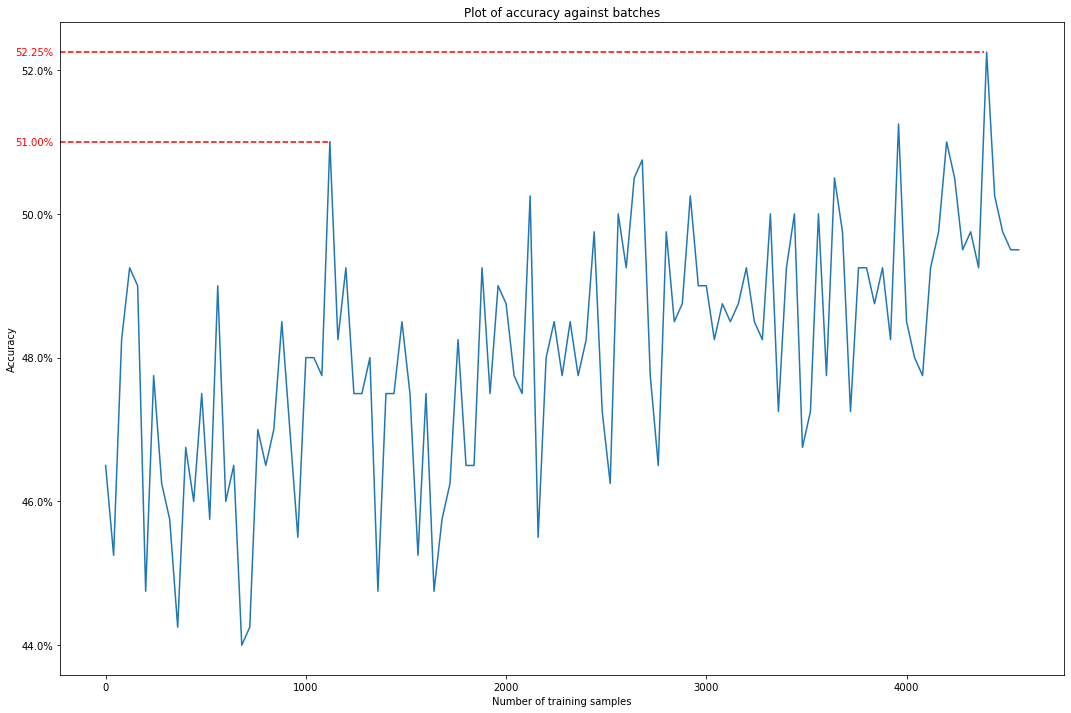

In [155]:
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick

fig, ax=plt.subplots()
ax.plot(batches_['Batch'], batches_['Accuracy'])
ax.axhline(y=52.25,linestyle='--',color='red',xmax=0.92)
ax.axhline(y=51.0,linestyle='--',color='red',xmax=0.27)
#ax.axvline(x=1120,linestyle='--',color='red',ymax=0.81)
#ax.axvline(x=4400,linestyle='--',color='red',ymax=0.93)
plt.title('Plot of accuracy against batches')
fig.set_size_inches(18, 12)
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,52.25, "{:.2f}{}".format(52.25, '%'), color="red", transform=trans, 
        ha="right", va="center")
ax.text(0,51.0, "{:.2f}{}".format(51.0, '%'), color="red", transform=trans, 
        ha="right", va="center")
ax.set_xlabel("Number of training samples")
ax.set_ylabel("Accuracy")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Confusion matrix

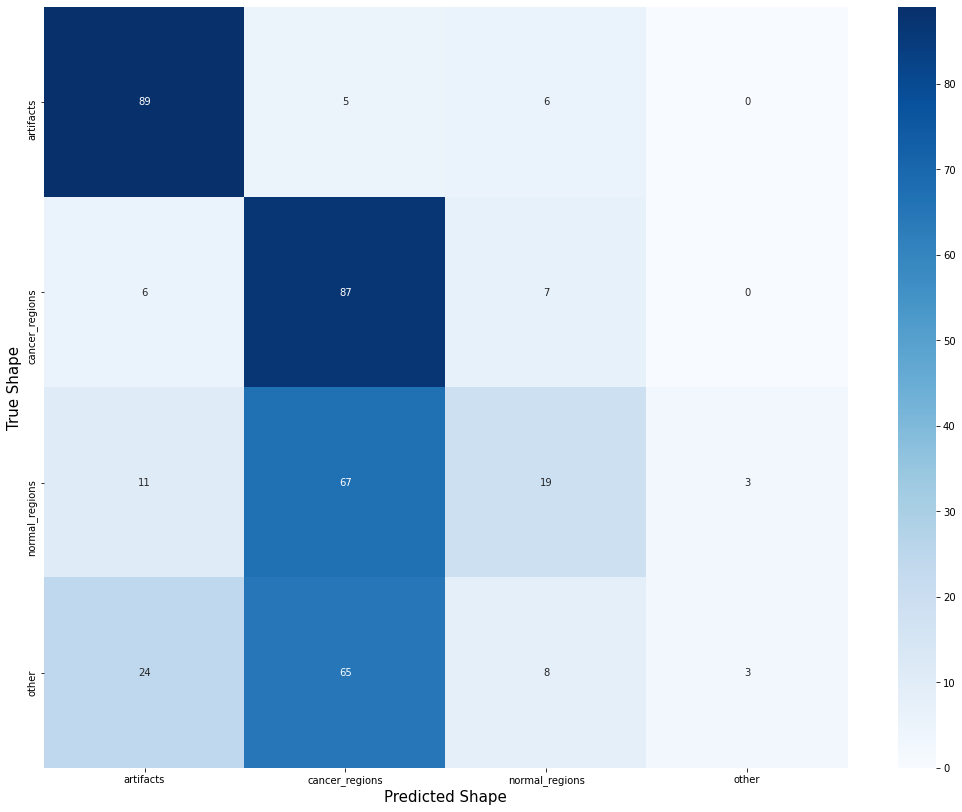

In [35]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (18,14))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 15)
plt.ylabel("True Shape", fontsize = 15)
plt.show()

batches_ = pd.DataFrame(
    {'Batch': batches_,
     'Accuracy': accuracy
    })

batches_